In [1]:
#Python - 3.9.13
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn
#!pip install tensorflow
#!pip install sklearn
#!pip install statsmodels==0.13.2 --user
#!pip install sktime
#!pip install xgboost
#!pip install skforecast
#!pip install Prophet
#!pip install --upgrade plotly

# Projeto Integrador Final
Predição do Faturamento de uma distribuidora de Implementos Médicos e Medicamentos buscando prever o Faturamento para o próximo Ano.
Grupo 4: Andreia Bacic, Alex Pivato, Guilherme Butzke, João Viana e Lucas Gentile

Modelos testados:
    1 - Tendência Linear
    2 - Tendência quadrática
    3 - Tendência com transformação logarítmica
    4 - Single Exponential Smoothing (suavização exponencial simples)
    5 - Triple Exponential Smoothing
    6 - ARIMA
    7 - SARIMA
    8 - Prophet
    9 - Xgboost
    10 - LSTM Rede Neural Profunda
    11 - Ensemble

Carregamento das bibliotecas

In [383]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import math
import os
import keras
import sklearn
import matplotlib.pyplot as plt
import warnings
import logging
import pickle

warnings.filterwarnings('ignore')
%config Completer.use_jedi = False

from pandas.tseries.offsets import DateOffset
from pandas.plotting import autocorrelation_plot

import statsmodels.api as sm
import statsmodels.formula.api as smf
from   statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from   statsmodels.tsa.holtwinters import SimpleExpSmoothing
from   statsmodels.tsa.stattools import adfuller
from   statsmodels.tsa.stattools import acf, pacf
from   statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from   statsmodels.tsa.arima_model import ARIMA
from   statsmodels.graphics.tsaplots import plot_predict
from   statsmodels.tsa.seasonal import seasonal_decompose
from   statsmodels.tsa.seasonal import STL
from   statsmodels.tsa.holtwinters import ExponentialSmoothing

from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.fbprophet import Prophet
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.datasets import load_airline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection._search import *

from keras.models import Sequential
from keras.layers import Dense,LSTM
from keras.metrics import RootMeanSquaredError
from keras.metrics import MeanSquaredError
from keras.metrics import MeanAbsolutePercentageError
from keras.optimizers import Adam

import xgboost as xgb
from   xgboost import plot_importance, plot_tree
from   xgboost import XGBRegressor

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster

Criação da função RMSE para calcular o Erro Quadrático Médio (RMSE)

def RMSE(predictions, targets):
    differences = predictions - targets                     
    differences_squared = differences ** 2                    
    mean_of_differences_squared = differences_squared.mean()  
    rmse_val = np.sqrt(mean_of_differences_squared)           
    return rmse_val 

In [384]:
df_Results = pd.DataFrame(columns = ["Model","RMSE","MAE", "MAPE (%)","Valor Anual (R$)"])
def Metricas_(predictions, targets, nome):
    differences = predictions - targets                     
    differences_squared = differences ** 2                    
    mean_of_differences_squared = differences_squared.mean()
    model_RMSE = np.sqrt(mean_of_differences_squared)           
    model_MAPE = mean_absolute_percentage_error(targets, predictions).round(4)
    model_MAE  = mean_absolute_error(targets, predictions)
    nome = nome
    valor_anual = predictions.sum().round(2)
    df_Results.loc[-1] = [nome,model_RMSE,model_MAE,(model_MAPE*100),valor_anual]
    df_Results.index = df_Results.index+1
    df_Results.sort_index
    return model_MAPE*100, model_MAE, model_RMSE, nome, valor_anual


In [385]:
cmdstanpy_logger = logging.getLogger("cmdstanpy")
cmdstanpy_logger.disabled = True

# EDA - Análise Exploratória dos Dados

Carregamento dos Dados da planilha excel

In [419]:
%%time
#data_location = "../Projeto Final/data/Faturamento.csv"
data_location = "../projeto-integrador-final/data/Faturamento.csv"
data = pd.read_csv(data_location, sep = ";", encoding="latin-1", low_memory=False)

CPU times: total: 297 ms
Wall time: 300 ms


Seleção dos primeiros registros para verificação dos dados

In [420]:
data.head(5)

,ANO,MES,TRIMESTRE,DESCRICAO_GRUPO,UF,CIDADE,ELEICAO_MUNICIPAL,ELEICAO_FEDERAL,VARIACAO_DOLAR,INFLACAO,PIB,VALOR
0,2014,5,2,SANEANTES,SC,RIO DO SUL,0,1,"14,40010277","6,41","0,5","1868,99"
1,2014,6,2,PRODUTOS PARA SAUDE,SC,RIO DO SUL,0,1,"14,40010277","6,41","0,5","27279,04"
2,2014,7,3,LABORATORIO,SC,RIO DO SUL,0,1,"14,40010277","6,41","0,5","214,12"
3,2016,6,2,PRODUTOS PARA SAUDE,SC,RIO DO SUL,1,0,"-12,59075524","6,29","-3,3","46374,06"
4,2017,1,1,PRODUTOS PARA SAUDE,SC,RIO DO SUL,0,0,"-2,944132427","2,95","1,3","32043,56"


Verificando o total de registros carregados

In [421]:
print("Total rows: {0}".format(len(data)))

Total rows: 164959


Verificando se colunas e linhas, se existe dados nulos, estatísticas e detalhes das colunas

In [422]:
print('\nConjunto de dados, linhas e colunas\n')
print('Shape:',data.shape)
print('\n---------------------------------------------\n')

print('\nCheck valores nulos\n')
print('Check nulos: \n')
print(pd.isnull(data).sum())
print('\n---------------------------------------------\n')

print('\nEstatísticas\n')
print(data.describe())
print('\n---------------------------------------------\n')

print('\nInformações do dataset\n')
print(data.info())
print('\n---------------------------------------------\n')



Conjunto de dados, linhas e colunas

Shape: (164959, 12)

---------------------------------------------


Check valores nulos

Check nulos: 

ANO                  0
MES                  0
TRIMESTRE            0
DESCRICAO_GRUPO      0
UF                   0
CIDADE               0
ELEICAO_MUNICIPAL    0
ELEICAO_FEDERAL      0
VARIACAO_DOLAR       0
INFLACAO             0
PIB                  0
VALOR                0
dtype: int64

---------------------------------------------


Estatísticas

                 ANO            MES      TRIMESTRE  ELEICAO_MUNICIPAL  \
count  164959.000000  164959.000000  164959.000000      164959.000000   
mean     2016.810504       6.582460       2.527774           0.230730   
std         3.693909       3.262456       1.075713           0.421301   
min      2008.000000       1.000000       1.000000           0.000000   
25%      2014.000000       4.000000       2.000000           0.000000   
50%      2017.000000       7.000000       3.000000           0.0000

Análise da Correlação das colunas

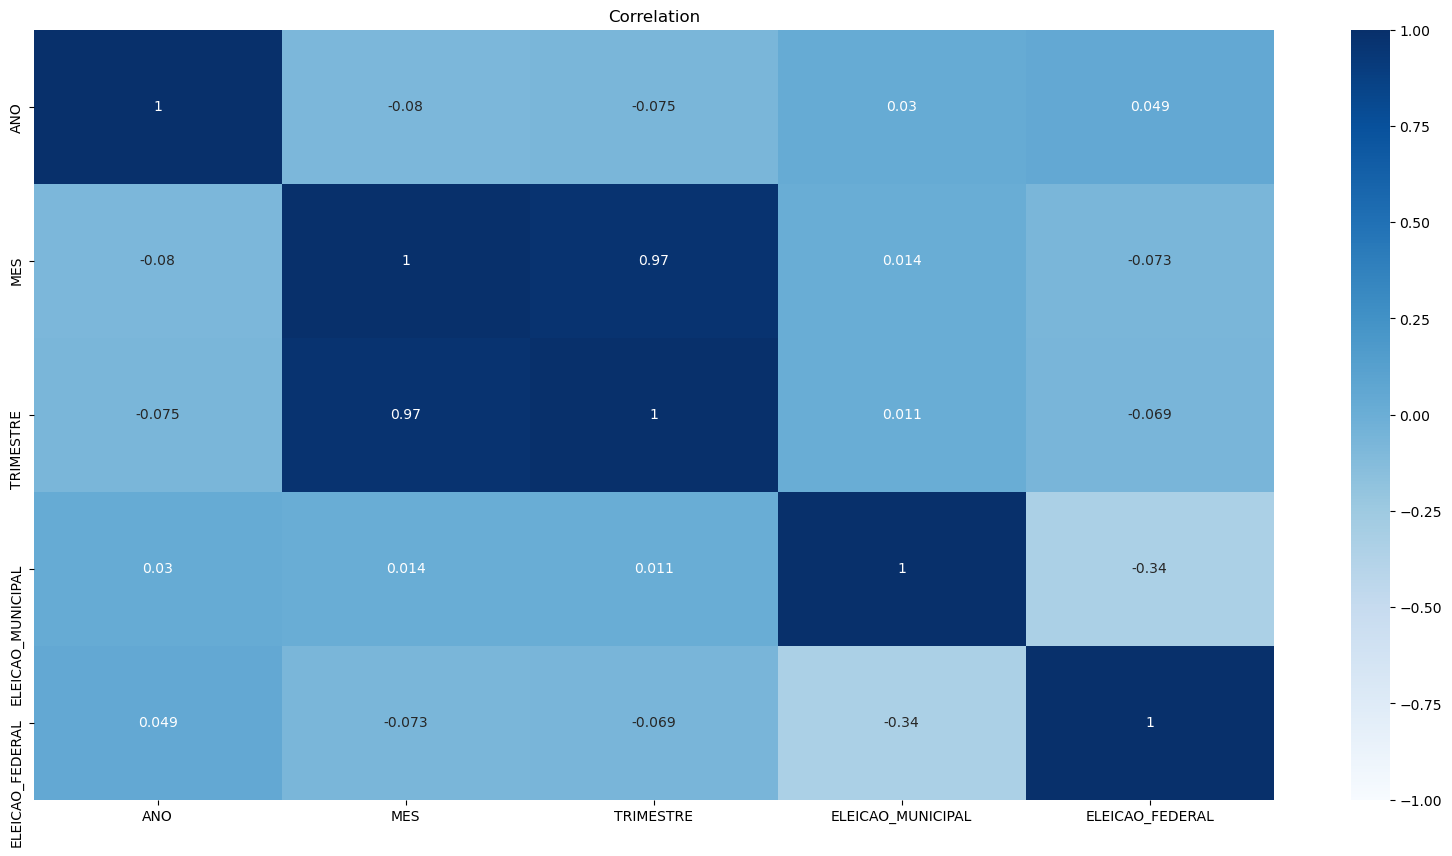

In [423]:
plt.figure(figsize = (20,10))
plt.title('Correlation')
sns.heatmap(data.corr(), 
            annot = True, 
            vmin = -1, 
            cmap = 'Blues'
           );
#plt.savefig("../Correlation1.png", dpi = 600 )

Agrupamento dos dados por Ano

In [424]:
data.groupby('ANO').sum()

,MES,TRIMESTRE,ELEICAO_MUNICIPAL,ELEICAO_FEDERAL
ANO,,,,
2008,3312,1104,276,0
2009,36927,14100,0,0
2010,41574,15852,0,6115
2011,48681,18506,0,0
2012,47973,18535,7457,0
2013,57444,21962,0,0
2014,73459,27997,0,10497
2015,80293,30666,0,0
2016,83735,31990,12682,0


Alteração da coluna VALOR que é a variável target a ser observada de object para float e substituição das virgulas por .

In [425]:
data['VALOR'] =data['VALOR'].apply(lambda x: x.replace(',', '.')).astype('float')

Plot VALOR

Verificando a distribuição do Valor total vendido por cada Ano

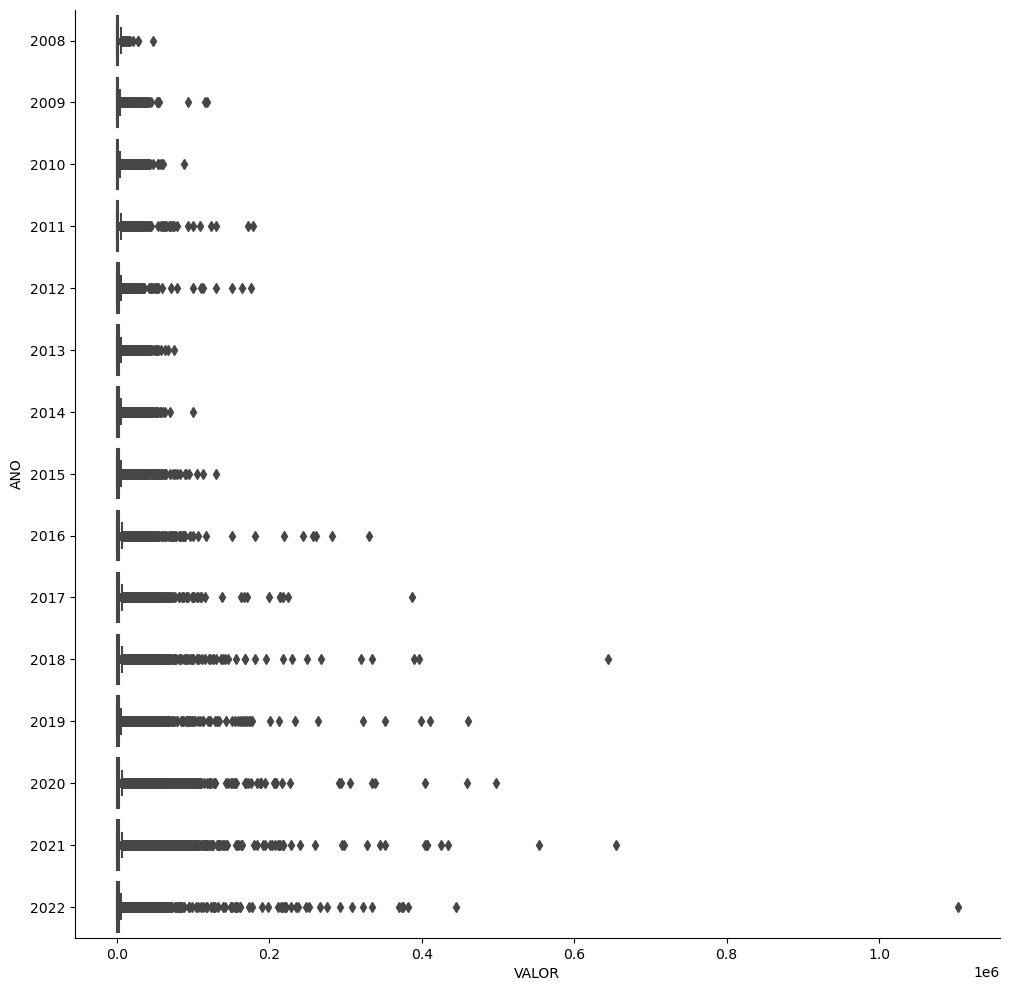

In [426]:
sns.catplot(y="ANO", x="VALOR",
                data=data.sort_values(by='ANO', ascending=False), kind="box",
                height=10, orient='h');

Análise da distribuição minimos e máximo do Valor total de vendas

In [427]:
data.VALOR.describe()

count    1.649590e+05
mean     3.066546e+03
std      1.103993e+04
min      4.000000e-02
25%      2.456000e+02
50%      8.281000e+02
75%      2.547720e+03
max      1.102818e+06
Name: VALOR, dtype: float64

Alteração do data type das colunas ANO e MES para string

In [428]:
data["ANO"] = data["ANO"].astype("str")
data["MES"] = data["MES"].astype("str")

Criação de uma nova coluna DATA concatenando o mês e o ano e convertendo para datetime

In [429]:
s_mes = data.MES
data["MES"] = s_mes.str.zfill(2)
data['DATA']= '01' + data.MES + data.ANO
data['DATA']=pd.to_datetime(data['DATA'], format='%d%m%Y')
data[['ANO','MES','DATA']]

,ANO,MES,DATA
0,2014,05,2014-05-01
1,2014,06,2014-06-01
2,2014,07,2014-07-01
3,2016,06,2016-06-01
4,2017,01,2017-01-01
...,...,...,...
164954,2022,03,2022-03-01
164955,2022,08,2022-08-01
164956,2016,10,2016-10-01
164957,2016,10,2016-10-01


Criação de um dataframe que será usado posteriormente para o streamlip

In [430]:
dt_ano = data.loc[:, ['DATA','VALOR']]

Criação de uma datagroup agrupando as Datas com a soma do valor total de vendas e definição do indice por DATA

In [183]:
gb_vendas = data.groupby('DATA')['VALOR'].sum().reset_index()
gb_vendas = data.set_index('DATA')

Criação do dataframe df_vendas_ano a partir de datagroup criado anteriormente.
Foi utilizada a função resample, levando a série para um espaço de tempo maior.
No nosso caso, passamos de dias para meses; MS indica "no início do mês".
E com a função mean() agrupamos todas as vendas do mês e calculamos a média.

In [184]:
df_vendas_ano = gb_vendas['VALOR'].resample('MS').mean().to_frame();
df_vendas_ano.head()

,VALOR
DATA,
2008-12-01,2124.826051
2009-01-01,1365.677737
2009-02-01,1442.712601
2009-03-01,2351.546014
2009-04-01,2144.901965


Ordenação dos dados pela coluna DATA

In [185]:
df_vendas_ano = df_vendas_ano.sort_values(by = "DATA")

Verificando a quatidade de colunas e linhas da série criada

In [186]:
df_vendas_ano.shape

(165, 1)

Análise gráfica da série

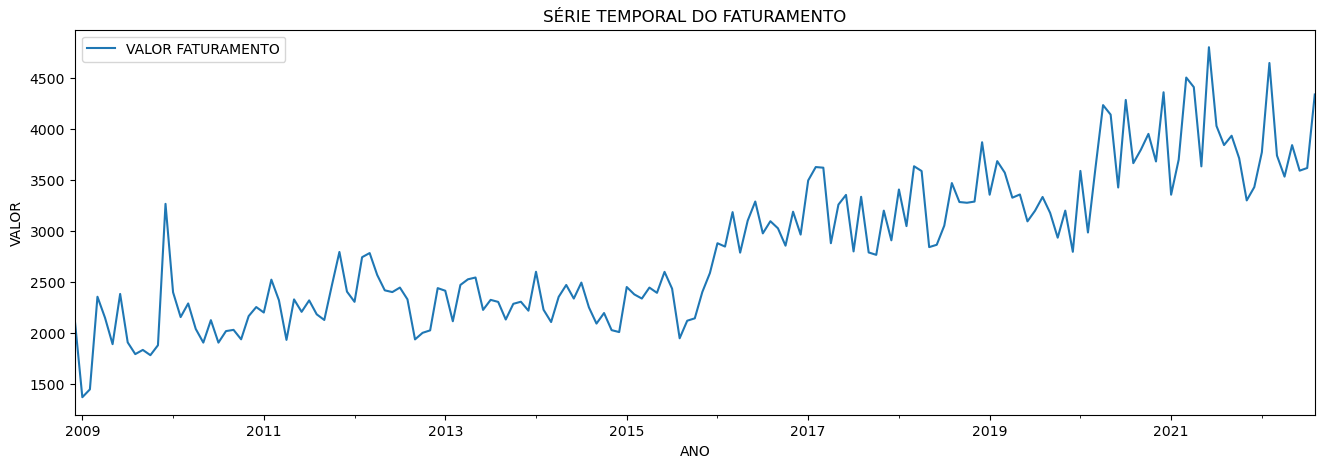

In [187]:
df_vendas_ano.plot(figsize=(16,5));
plt.xlabel('ANO')
plt.ylabel('VALOR')
plt.title('SÉRIE TEMPORAL DO FATURAMENTO')
plt.legend(['VALOR FATURAMENTO'])
#plt.savefig("../Serie Temporal.png", dpi = 600 )

Observando a decomposição da sazonalidade da serie

In [188]:
stl=STL(df_vendas_ano).fit()

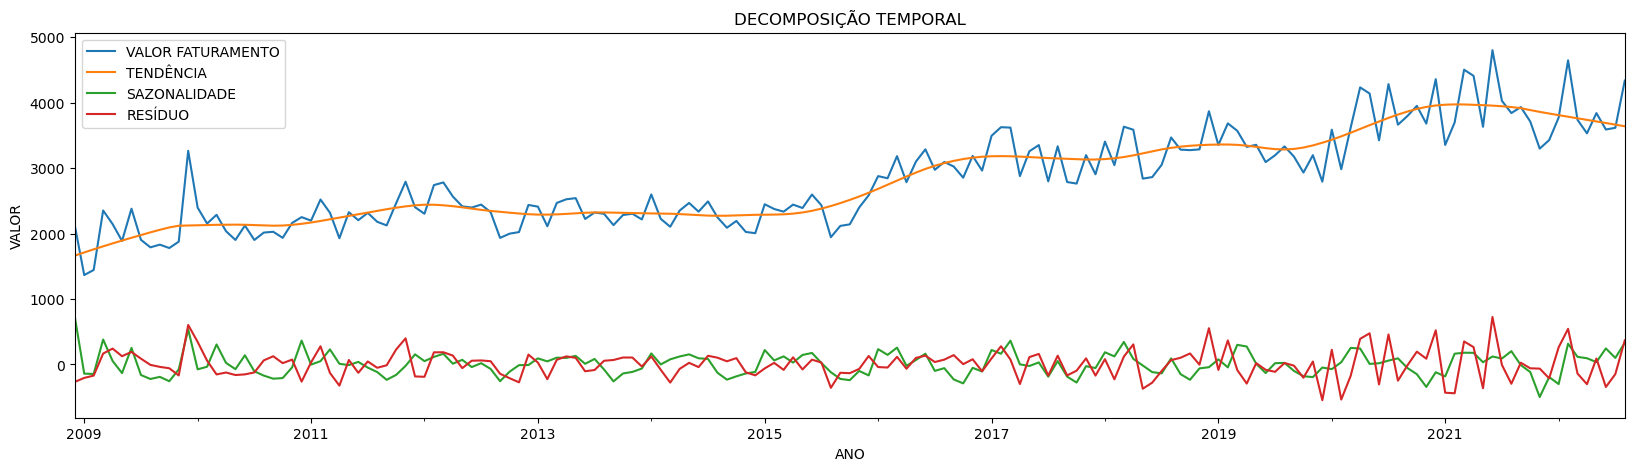

In [189]:
stl.observed.plot(figsize=(20,5))
stl.trend.plot(figsize=(20,5))
stl.seasonal.plot(figsize=(20,5))
stl.resid.plot(figsize=(20,5))
plt.title('DECOMPOSIÇÃO TEMPORAL')
plt.xlabel('ANO')
plt.ylabel('VALOR')
plt.legend(['VALOR FATURAMENTO','TENDÊNCIA','SAZONALIDADE', 'RESÍDUO'])
#plt.savefig("../Decomposição.png", dpi = 600 )

# CRIAÇÃO DOS MODELOS DE SÉRIES TEMPORAIS

# 1- Tendência Linear

Criação de um dataframe que será utilizado para o modelo de Tendencia Linear

In [191]:
df_vendas_model1 = df_vendas_ano[['VALOR']]
print('df_vendas_ano: ', df_vendas_ano.shape, 'df_vendas_model1: ', df_vendas_model1.shape)

df_vendas_ano:  (165, 1) df_vendas_model1:  (165, 1)


In [192]:
df_vendas_model1.head()

,VALOR
DATA,
2008-12-01,2124.826051
2009-01-01,1365.677737
2009-02-01,1442.712601
2009-03-01,2351.546014
2009-04-01,2144.901965


Fazemos a modelagem da série com time dummy DATAINDEX para o modelo de tendencia linear 

In [193]:
df_vendas_model1["DATAINDEX"] = pd.Series(np.arange(len(df_vendas_model1['VALOR'])), index = df_vendas_model1.index)
df_vendas_model1.DATAINDEX.head(3)

DATA
2008-12-01    0
2009-01-01    1
2009-02-01    2
Freq: MS, Name: DATAINDEX, dtype: int32

Verificando os primeiros registros da série

In [194]:
df_vendas_model1.head()

,VALOR,DATAINDEX
DATA,,
2008-12-01,2124.826051,0
2009-01-01,1365.677737,1
2009-02-01,1442.712601,2
2009-03-01,2351.546014,3
2009-04-01,2144.901965,4


Separação do modelo de treino e teste

In [195]:
df_train, df_test = train_test_split(df_vendas_model1, test_size = 12, random_state = 42, shuffle = False)

Instanciamento do modelo linear com OLS para fazer a regressão linear com duas variáveis VALOR e DATAINDEX 

In [196]:
sm.OLS.from_formula

<bound method Model.from_formula of <class 'statsmodels.regression.linear_model.OLS'>>

In [197]:
model_linear = smf.ols(formula = 'VALOR ~ DATAINDEX', data = df_train).fit()

Geração das previsões do conjunto de treino e teste

In [198]:
df_train["LinearTrend"] = model_linear.predict(df_train.DATAINDEX)
df_test["LinearTrend"] = model_linear.predict(df_test.DATAINDEX)

Criação de um novo dataframe para armazenar as previsões do modelo

In [199]:
df_linear = model_linear.predict(df_test.DATAINDEX)
df_linear_train = df_train["LinearTrend"]
df_linear

DATA
2021-09-01    3768.661924
2021-10-01    3781.848274
2021-11-01    3795.034624
2021-12-01    3808.220975
2022-01-01    3821.407325
2022-02-01    3834.593675
2022-03-01    3847.780025
2022-04-01    3860.966376
2022-05-01    3874.152726
2022-06-01    3887.339076
2022-07-01    3900.525426
2022-08-01    3913.711777
dtype: float64

Análise gráfica das predições do treino e teste

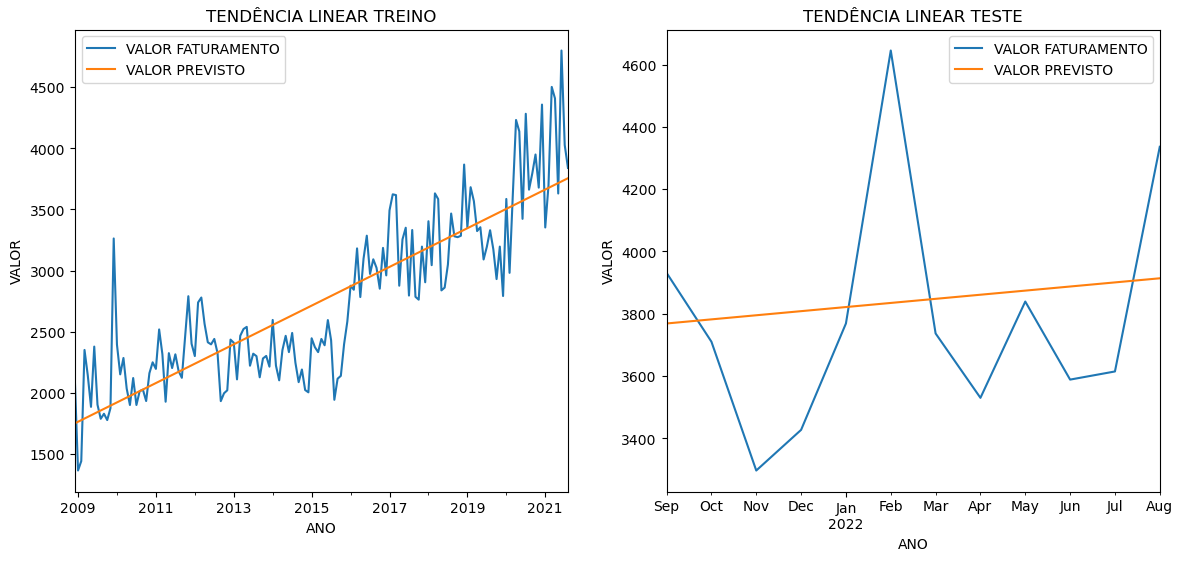

In [200]:
fig, axes = plt.subplots(1, 2,figsize = (14, 6))
df_train.plot(kind = "line", y = ["VALOR","LinearTrend"], ax = axes[0], title = 'TENDÊNCIA LINEAR TREINO');
axes[0].set_xlabel('ANO')
axes[0].set_ylabel('VALOR')
axes[0].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
df_test.plot(kind = "line", y = ["VALOR","LinearTrend"], ax = axes[1], title = 'TENDÊNCIA LINEAR TESTE');
axes[1].set_xlabel('ANO')
axes[1].set_ylabel('VALOR')
axes[1].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
#plt.savefig("../Tendencia Linear.png", dpi = 600 )

Calculamos o desempenho com as métricas RMSE, MAPE, MAE

In [201]:
Metricas_(df_test['LinearTrend'], df_test['VALOR'], 'Tendência Linear')

(7.53, 288.4273605797561, 360.23717185738263, 'Tendência Linear', 46094.24)

Colocando as metricas dentro de um dataframe

In [202]:
df_Results

,Model,RMSE,MAE,MAPE (%),Valor Anual (R$)
0,Tendência Linear,360.237172,288.427361,7.53,46094.24


Resultado do modelo Linear Trend com summary 

In [203]:
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  VALOR   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     397.7
Date:                Thu, 13 Oct 2022   Prob (F-statistic):           3.72e-44
Time:                        15:22:09   Log-Likelihood:                -1117.2
No. Observations:                 153   AIC:                             2238.
Df Residuals:                     151   BIC:                             2244.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1751.1503     58.119     30.130      0.000    1636.319    1865.982
DATAINDEX     13.1864      0.661     19.944      0.000      11.880      14.493
==============================================================================
Omnibus:                       10.223   Durbin-Watson:                   1.126
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               11.124
Skew:                           0.506   Prob(JB):                      0.00384
Kurtosis:                       3.849   Cond. No.                         175.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 2 - Tendência quadrática

Elevamos a dummy de tempo DATAINDEX ao quadrado para fazer o modelo de Tendencia quadrática

In [204]:
df_vendas_model1["DATAINDEX_SQ"] = df_vendas_model1["DATAINDEX"] ** 2
df_vendas_model1.DATAINDEX_SQ.head(3)

DATA
2008-12-01    0
2009-01-01    1
2009-02-01    4
Freq: MS, Name: DATAINDEX_SQ, dtype: int32

Separação dos dados de treino e teste

In [205]:
df_train, df_test = train_test_split(df_vendas_model1, test_size = 12, random_state = 42, shuffle = False)

Adicionamos a variável da tendencia quadrática criada acima na fórmula do modelo

In [206]:
model_quadratic = smf.ols('VALOR ~ DATAINDEX + DATAINDEX_SQ', data = df_train).fit()

Geramos as previsões do modelo

In [207]:
df_train["QUADRATIC_TEND"] = model_quadratic.predict(df_train[["DATAINDEX","DATAINDEX_SQ"]])
df_test["QUADRATIC_TEND"] = model_quadratic.predict(df_test[["DATAINDEX","DATAINDEX_SQ"]])

Representação gráfica das previsões do modelo de tendencia quadrática

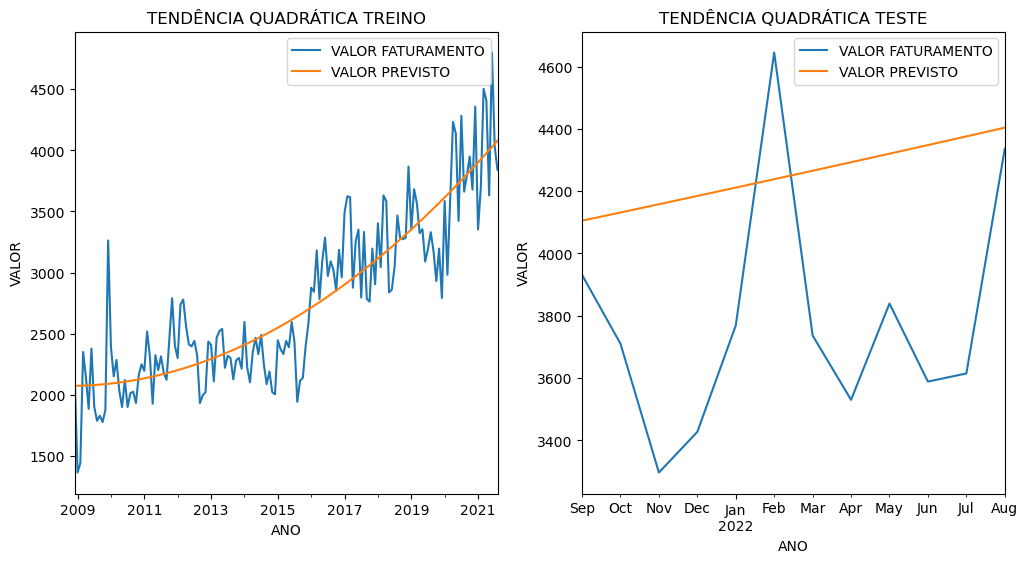

In [208]:
fig, axes = plt.subplots(1, 2,figsize = (12, 6))
df_train.plot(kind = "line", y = ["VALOR","QUADRATIC_TEND"], ax = axes[0], title = 'TENDÊNCIA QUADRÁTICA TREINO');
df_test.plot(kind = "line", y = ["VALOR","QUADRATIC_TEND"], ax = axes[1], title = 'TENDÊNCIA QUADRÁTICA TESTE');
axes[0].set_xlabel('ANO')
axes[0].set_ylabel('VALOR')
axes[0].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
axes[1].set_xlabel('ANO')
axes[1].set_ylabel('VALOR')
axes[1].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
#plt.savefig("../Tendendia Quadratica.png", dpi = 600 )

df_testCalculamos o desempenho com as métricas RMSE, MAPE, MAE

In [209]:
Metricas_(df_test['QUADRATIC_TEND'], df_test['VALOR'], 'Tendendia Quadratica')

(14.71, 535.3436012597027, 587.2236008366383, 'Tendendia Quadratica', 51034.1)

Inclusão dos resultados RMSE, MAPE e MAE do desempenho do modelo no dataframe df_Results

In [210]:
df_Results

,Model,RMSE,MAE,MAPE (%),Valor Anual (R$)
1,Tendência Linear,360.237172,288.427361,7.53,46094.24
0,Tendendia Quadratica,587.223601,535.343601,14.71,51034.10


Resultado da tendencia quadrática com summary

In [211]:
model_quadratic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  VALOR   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     253.0
Date:                Thu, 13 Oct 2022   Prob (F-statistic):           8.67e-49
Time:                        15:22:12   Log-Likelihood:                -1103.0
No. Observations:                 153   AIC:                             2212.
Df Residuals:                     150   BIC:                             2221.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     2074.6669     79.088     26.232      0.000    1918.397    2230.937
DATAINDEX        0.3314      2.404      0.138      0.891      -4.419       5.082
DATAINDEX_SQ     0.0846      0.015      5.524      0.000       0.054       0.115
==============================================================================
Omnibus:                        4.186   Durbin-Watson:                   1.354
Prob(Omnibus):                  0.123   Jarque-Bera (JB):                3.708
Skew:                           0.316   Prob(JB):                        0.157
Kurtosis:                       3.426   Cond. No.                     3.08e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.08e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 3 -  Tendência com transformação logarítmica

Geramos o modelo sobre o logaritmo das vendas e suas previsões.

In [212]:
df_train['LOG_VALOR'] = np.log(df_train['VALOR'])
df_test['LOG_VALOR'] = np.log(df_test['VALOR'])

Observamos o valores de treino e teste com a calculo logarítimo

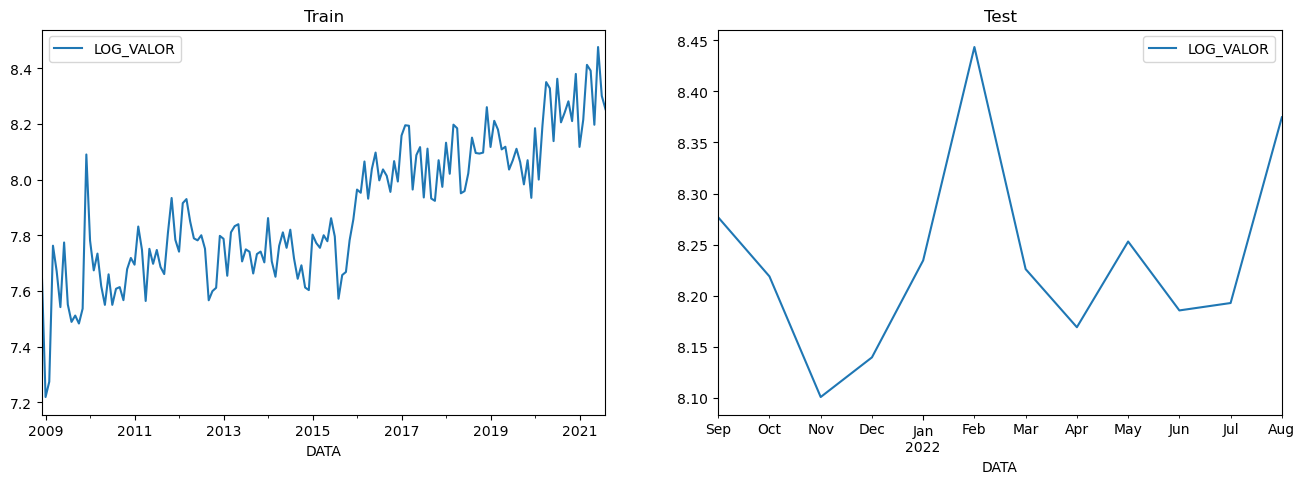

In [213]:
fig, axes = plt.subplots(1, 2,figsize = (16, 5))
df_train.plot(kind = "line", y = ["LOG_VALOR"], ax = axes[0], title = 'Train');
df_test.plot(kind = "line", y = ["LOG_VALOR"], ax = axes[1], title = 'Test');
plt.show()

Geramos o modelo de regressão linear usando o logarítimo do valor

In [214]:
model_log = smf.ols('LOG_VALOR ~ DATAINDEX ', data = df_train).fit()

É feita a previsão dos modelos treino e teste das variáveis logarítima

In [215]:
df_train["LOG_TREND"] = model_log.predict(df_train[["DATAINDEX"]])
df_test["LOG_TREND"] = model_log.predict(df_test[["DATAINDEX"]])

Recuperamos o valor previsto do valor aplicando a função exponencial nas previsões.

In [216]:
df_train['BACK_LOG_TREND'] = np.exp(df_train['LOG_TREND'])
df_test['BACK_LOG_TREND'] = np.exp(df_test['LOG_TREND'])

Representação gráfica das previsões do modelo com transformação logarítima

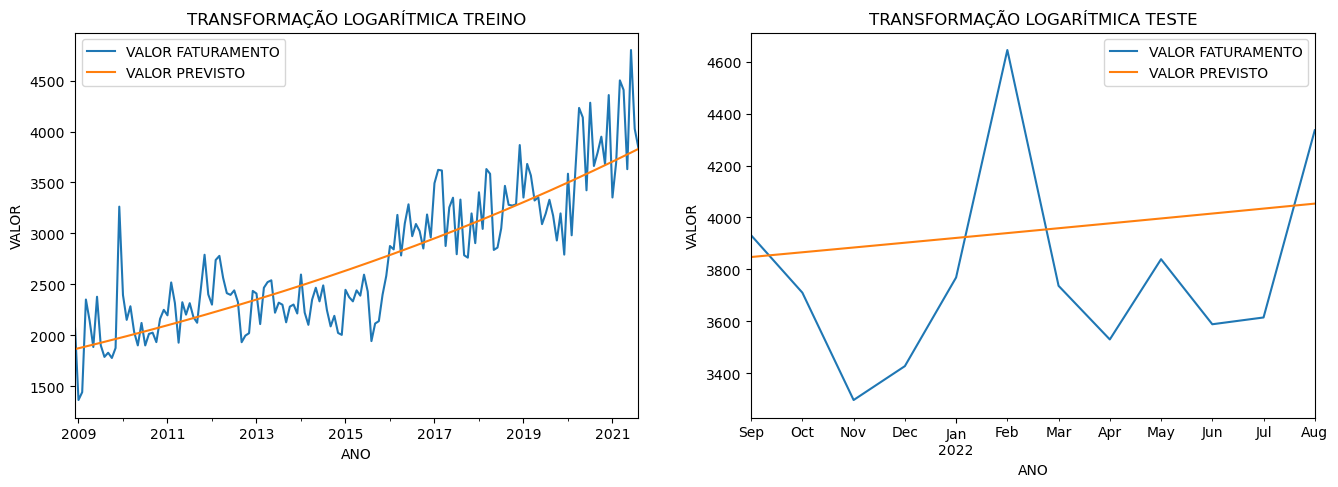

In [217]:
fig, axes = plt.subplots(1, 2,figsize = (16, 5))
df_train.plot(kind = "line", y = ["VALOR", "BACK_LOG_TREND"], ax = axes[0], title = 'TRANSFORMAÇÃO LOGARÍTMICA TREINO');
df_test.plot(kind = "line", y = ["VALOR", "BACK_LOG_TREND"], ax = axes[1], title = 'TRANSFORMAÇÃO LOGARÍTMICA TESTE');
axes[0].set_xlabel('ANO')
axes[0].set_ylabel('VALOR')
axes[0].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
axes[1].set_xlabel('ANO')
axes[1].set_ylabel('VALOR')
axes[1].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
#plt.savefig("../Transformação Logarítmica.png", dpi = 600 )

Calculamos o desempenho com as métricas RMSE, MAPE, MAE 

In [218]:
Metricas_(df_test['BACK_LOG_TREND'], df_test['VALOR'], 'Transformação Logarítmica')

(9.16,
 342.8938887043975,
 391.027823615976,
 'Transformação Logarítmica',
 47394.84)

Inclusão dos resultados RMSE, MAPE e MAE do desempenho do modelo no dataframe df_Results

In [219]:
df_Results

,Model,RMSE,MAE,MAPE (%),Valor Anual (R$)
2,Tendência Linear,360.237172,288.427361,7.53,46094.24
1,Tendendia Quadratica,587.223601,535.343601,14.71,51034.10
0,Transformação Logarítmica,391.027824,342.893889,9.16,47394.84


# 4 - Single Exponential Smoothing

Definimos 3 valores para os fatores de suavização 0.3, 0.5 e 0.8 para analisar qual modelo traz o melhor resultado

In [220]:
model_exp_smoothing_03 = SimpleExpSmoothing(df_train.VALOR).fit(smoothing_level = 0.3, optimized = False)
model_exp_smoothing_05 = SimpleExpSmoothing(df_train.VALOR).fit(smoothing_level = 0.5, optimized = False)
model_exp_smoothing_08 = SimpleExpSmoothing(df_train.VALOR).fit(smoothing_level = 0.8, optimized = False)

Previsão do modelo de teste com os 3 fatores de suavização

In [221]:
df_test["Simple Smoothing 03"] = model_exp_smoothing_03.forecast(len(df_test))
df_test["Simple Smoothing 05"] = model_exp_smoothing_05.forecast(len(df_test))
df_test["Simple Smoothing 08"] = model_exp_smoothing_08.forecast(len(df_test))

Observamos no treino os resultados com os três fatores de suavização

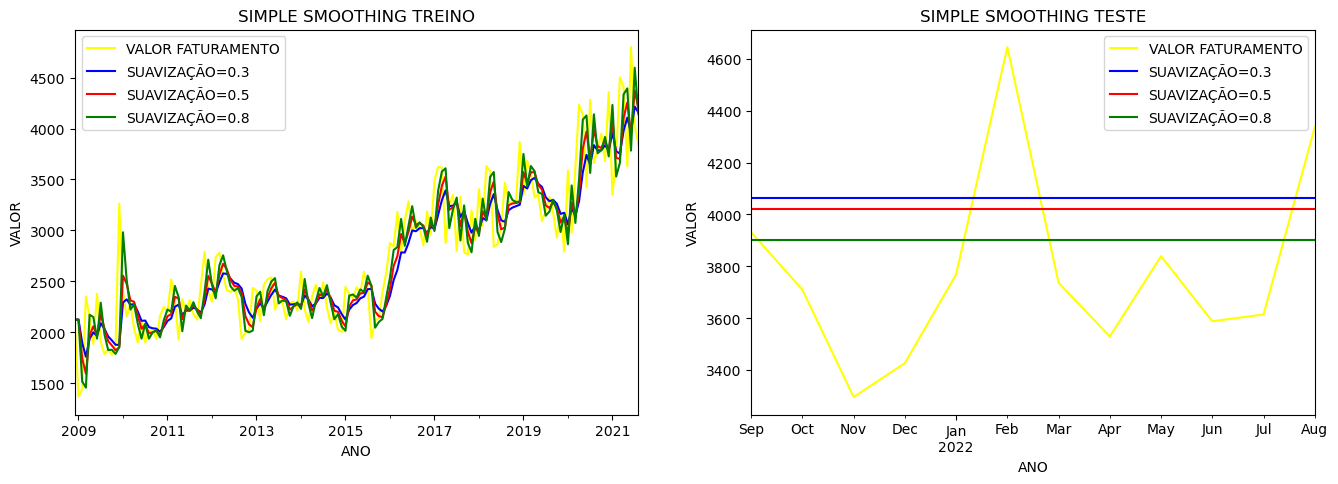

In [222]:
fig, axes = plt.subplots(1, 2,figsize = (16, 5))
df_train.plot(kind = "line", label = "VALOR FATURAMENTO",y = "VALOR", color = 'yellow',ax = axes[0])
df_test.plot(kind = "line", label = "VALOR FATURAMENTO",y = "VALOR", color = 'yellow',ax = axes[1])
model_exp_smoothing_03.fittedvalues.plot(label = "SUAVIZAÇÃO=0.3", color = 'b', xlabel='ANO', ylabel='VALOR',ax = axes[0])
model_exp_smoothing_05.fittedvalues.plot(label = "SUAVIZAÇÃO=0.5", color = 'r', xlabel='ANO', ylabel='VALOR',ax = axes[0])
model_exp_smoothing_08.fittedvalues.plot(label = "SUAVIZAÇÃO=0.8", color = 'g', xlabel='ANO', ylabel='VALOR',ax = axes[0])
axes[0].set_title('SIMPLE SMOOTHING TREINO')
axes[0].legend();
df_test["Simple Smoothing 03"].plot(label = "SUAVIZAÇÃO=0.3", color = 'b', xlabel='ANO', ylabel='VALOR',ax = axes[1])
df_test["Simple Smoothing 05"].plot(label = "SUAVIZAÇÃO=0.5", color = 'r', xlabel='ANO', ylabel='VALOR',ax = axes[1])
df_test["Simple Smoothing 08"].plot(label = "SUAVIZAÇÃO=0.8", color = 'g', xlabel='ANO', ylabel='VALOR',ax = axes[1])
axes[1].set_title('SIMPLE SMOOTHING TESTE')
axes[1].legend();
#plt.savefig("../model_exp_smoothing_treino.png", dpi = 600 )


Calculamos o desempenho com as métricas RMSE, MAPE, MAE para os 3 modelos

In [223]:
Metricas_(df_test['Simple Smoothing 03'], df_test['VALOR'], 'Simple Smoothing 03')
Metricas_(df_test['Simple Smoothing 05'], df_test['VALOR'], 'Simple Smoothing 05')
Metricas_(df_test['Simple Smoothing 08'], df_test['VALOR'], 'Simple Smoothing 08')

(8.38, 316.6686795785804, 379.96812632603496, 'Simple Smoothing 08', 46798.41)

Inclusão dos resultados RMSE, MAPE e MAE do desempenho do modelo no dataframe df_Results

In [224]:
df_Results

,Model,RMSE,MAE,MAPE (%),Valor Anual (R$)
5,Tendência Linear,360.237172,288.427361,7.53,46094.24
4,Tendendia Quadratica,587.223601,535.343601,14.71,51034.10
3,Transformação Logarítmica,391.027824,342.893889,9.16,47394.84
2,Simple Smoothing 03,456.299725,420.013622,11.38,48752.43
1,Simple Smoothing 05,431.326468,391.123001,10.55,48232.39
0,Simple Smoothing 08,379.968126,316.668680,8.38,46798.41


# 5 Triple Exponential Smoothing

Divisão do treino e teste, definindo a previsão de 12 meses

In [225]:
test_months = 12
training_set = df_vendas_ano.iloc[:-test_months, :]
test_set = df_vendas_ano.iloc[-test_months:, :]

Estanciando o modelo Triple Exponential Smoothing

In [226]:
model = ExponentialSmoothing(endog = training_set.VALOR,
                             trend = 'add',
                             seasonal = 'mul',
                            seasonal_periods = 30).fit()

Gerando as previsões do modelo

In [227]:
predictions_hw = model.forecast(steps = len(test_set)).rename("HW")
treino_hw = model.fittedvalues
predictions_hw

2021-09-01    4118.586382
2021-10-01    4065.876084
2021-11-01    4246.375578
2021-12-01    4044.467172
2022-01-01    4164.651882
2022-02-01    4292.044742
2022-03-01    4222.585035
2022-04-01    3820.033934
2022-05-01    3984.433521
2022-06-01    4185.993312
2022-07-01    4168.736833
2022-08-01    4051.014930
Freq: MS, Name: HW, dtype: float64

Plot da previsão gerada pelo modelo

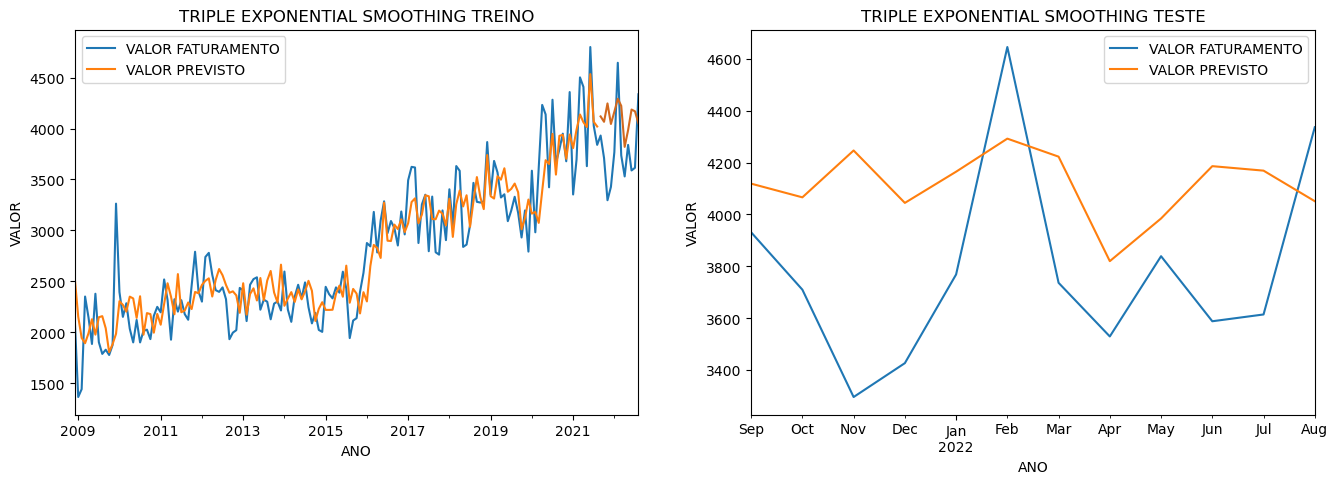

In [228]:
fig, axes = plt.subplots(1, 2,figsize = (16, 5))
df_vendas_ano['VALOR'].plot(ax = axes[0])
treino_hw.plot(ax = axes[0])
predictions_hw.plot(ax = axes[0], color = 'chocolate')
test_set['VALOR'].plot(ax = axes[1])
predictions_hw.plot(ax = axes[1])
axes[0].set_title('TRIPLE EXPONENTIAL SMOOTHING TREINO')
axes[0].set_xlabel('ANO')
axes[0].set_ylabel('VALOR')
axes[0].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
axes[1].set_title('TRIPLE EXPONENTIAL SMOOTHING TESTE')
axes[1].set_xlabel('ANO')
axes[1].set_ylabel('VALOR')
axes[1].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
#plt.savefig("../TRIPLE EXPONENTIAL SMOOTHING.png", dpi = 600 )

Calculamos o desempenho com as métricas RMSE, MAPE, MAE para os 3 modelos

In [229]:
Metricas_(predictions_hw, df_test['VALOR'], 'Triple Exponential Smoothing')

(11.899999999999999,
 434.7688747446593,
 484.16220842533033,
 'Triple Exponential Smoothing',
 49364.8)

Inclusão dos resultados RMSE, MAPE e MAE do desempenho do modelo no dataframe df_Results

In [230]:
df_Results

,Model,RMSE,MAE,MAPE (%),Valor Anual (R$)
6,Tendência Linear,360.237172,288.427361,7.53,46094.24
5,Tendendia Quadratica,587.223601,535.343601,14.71,51034.10
4,Transformação Logarítmica,391.027824,342.893889,9.16,47394.84
3,Simple Smoothing 03,456.299725,420.013622,11.38,48752.43
2,Simple Smoothing 05,431.326468,391.123001,10.55,48232.39
1,Simple Smoothing 08,379.968126,316.668680,8.38,46798.41
0,Triple Exponential Smoothing,484.162208,434.768875,11.90,49364.80


# 6 ARIMA

Verificando se a série é ou não estacionária com adfuller

In [231]:
def adfuller_test(vendas):
    result=adfuller(vendas)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

In [232]:
adfuller_test(df_vendas_ano['VALOR'])

ADF Test Statistic : -0.6028292677250977
p-value : 0.8703414458458909
#Lags Used : 10
Number of Observations : 154
weak evidence against null hypothesis,indicating it is non-stationary 


O valor de p obtido é superior ao nível de significância de 0,05 e a estatística ADF é superior a qualquer um dos valores críticos.
Portanto, não há razão para rejeitar a hipótese nula. Então, a série temporal é de fato não estacionária.
Então, no nosso caso, P Value > 0,05, prosseguimos com a determinação da ordem de diferenciação.

Função para plot do teste Dicket-Fuller, Análise do número p de lags (AR) para prever e do número do q (MA) derros de previsão defasados

In [233]:
def tsplot(y, lags = None, figsize = (12, 7), style = 'bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize = figsize)
        layout = (2, 2)
        
        # definimos eixos
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan = 2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        
        # obtém o valor p com h0: raiz unitária presente
        p_value = sm.tsa.stattools.adfuller(y)[1]
        
        ts_ax.set_title('Análise da Série de Tempo\Dickey-Fuller: p={0:.5f}'\
                        .format(p_value))
        
        # plot de autocorrelação
        sm.graphics.tsa.plot_acf(y, lags = lags, ax = acf_ax)
        # plot de autocorrelação parcial
        sm.graphics.tsa.plot_pacf(y, lags = lags, ax = pacf_ax)
        plt.tight_layout()

Plot da do teste Dicket-Fuller, autocorrelation r partial autocorrelation na série original 

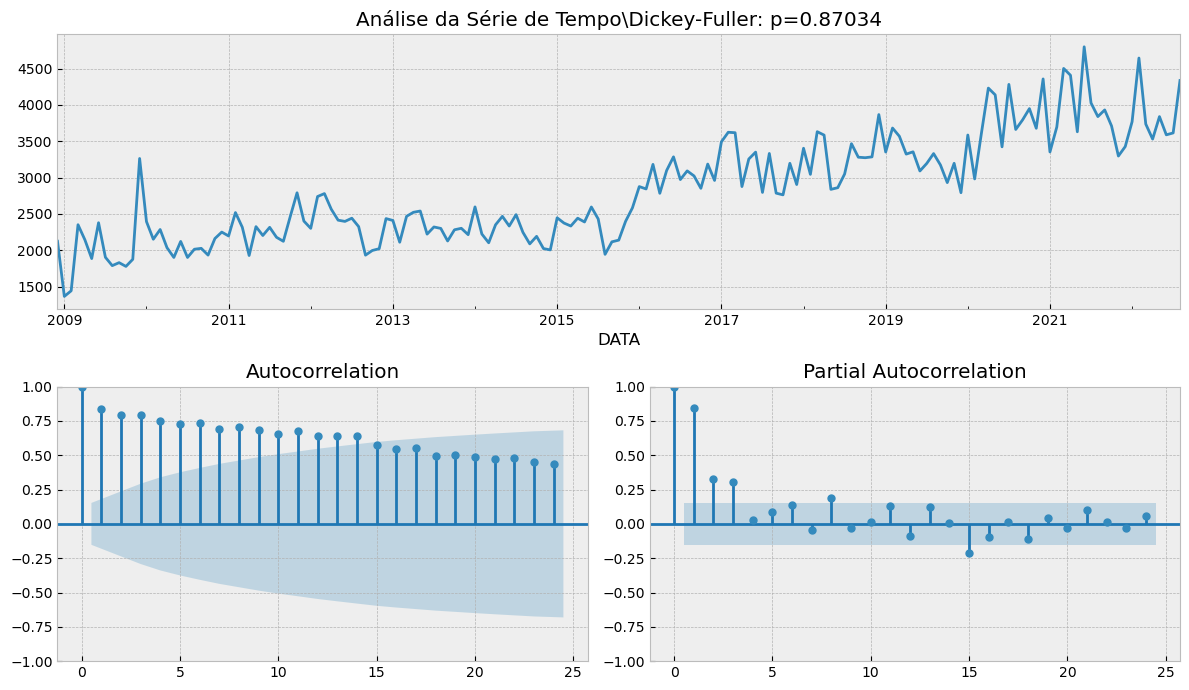

In [234]:
tsplot(df_vendas_ano.VALOR, lags = 24)

Plot da do teste Dicket-Fuller, autocorrelation r partial autocorrelation na série temporal com uma ordem de diferenciação.

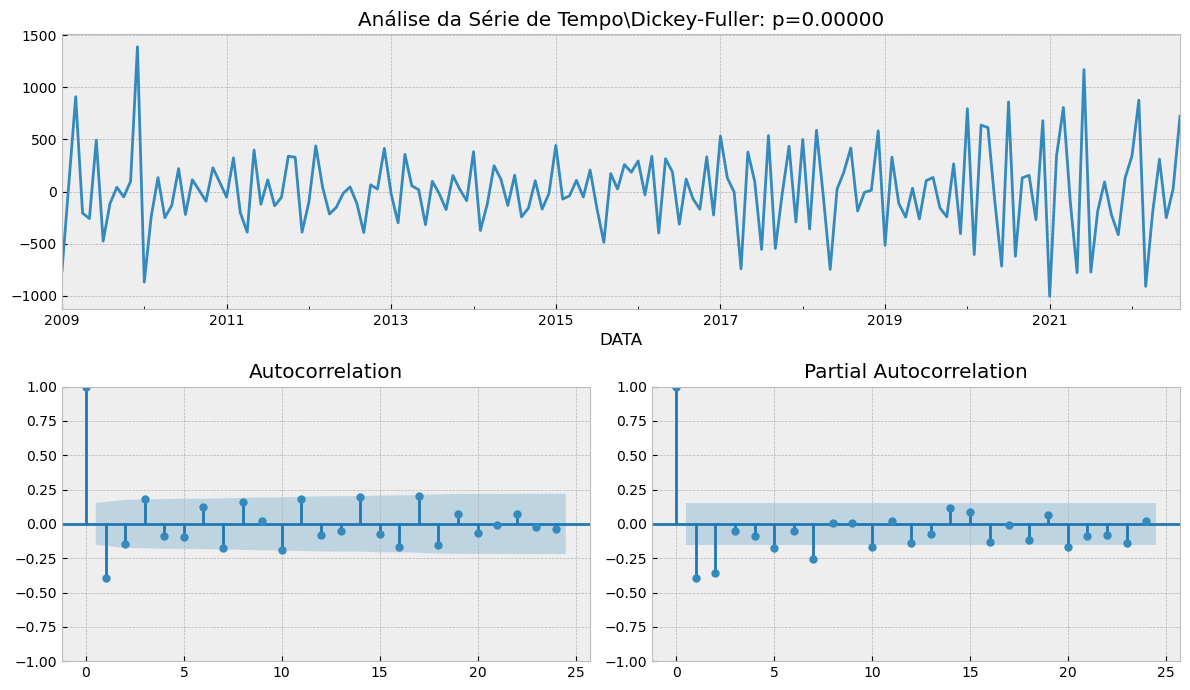

In [235]:
tsplot(df_vendas_ano.VALOR.diff().dropna(), lags = 24)

Plot da do teste Dicket-Fuller, autocorrelation r partial autocorrelation na série temporal com duas ordem de diferenciação.

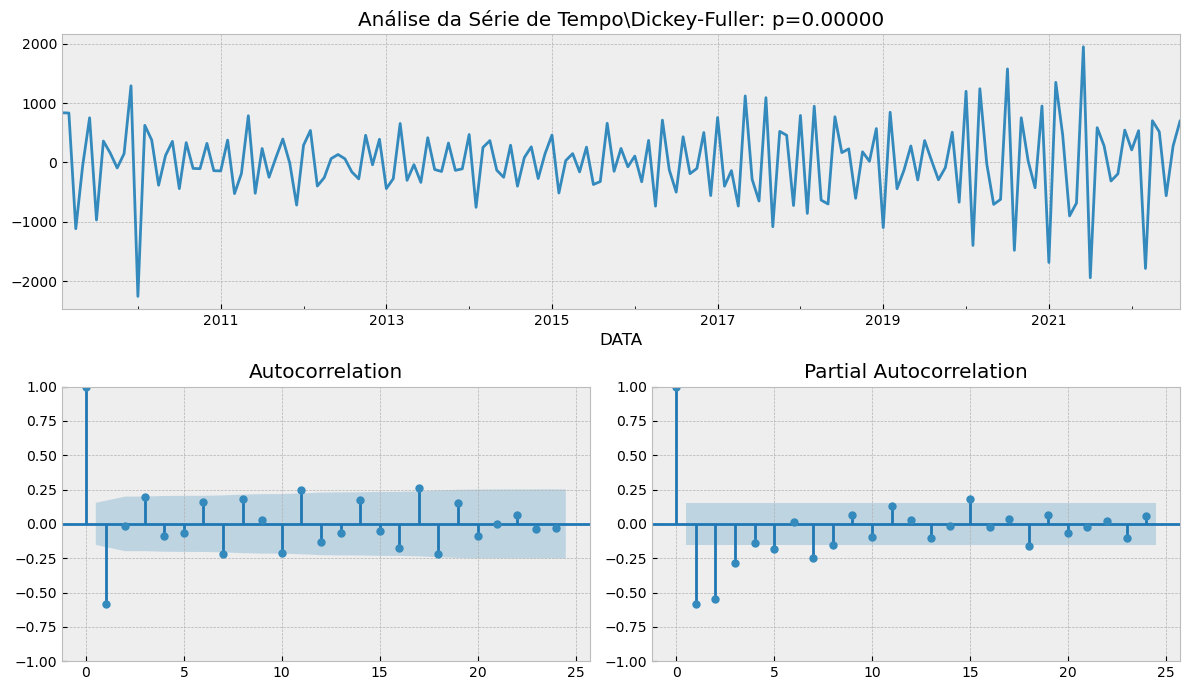

In [236]:
tsplot(df_vendas_ano.VALOR.diff().diff().dropna(), lags = 24)

Abaixo segue os teste do ARIMA com 4 combinações de parâmetros:
    #model_ARIMA_001: order 0, 0, 1
    model_ARIMA_002: order 0, 0, 2
    model_ARIMA_003: order 1, 1, 1
    model_ARIMA_004: order 1, 1, 2

Separando treino e teste para o modelo ARIMA

In [237]:
treino_ARIMA = df_vendas_ano['VALOR'].iloc[0:153]

Testando o modelo ARIMA com os valores 0,0,1 (model_ARIMA_001)

In [238]:
model_ARIMA_001 = sm.tsa.arima.ARIMA(treino_ARIMA, order=(0, 0, 1))
results_ARIMA_001 = model_ARIMA_001.fit()
print(results_ARIMA_001.summary())

                               SARIMAX Results                                
Dep. Variable:                  VALOR   No. Observations:                  153
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1169.755
Date:                Thu, 13 Oct 2022   AIC                           2345.511
Time:                        15:22:35   BIC                           2354.602
Sample:                    12-01-2008   HQIC                          2349.204
                         - 08-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2754.0643     81.950     33.607      0.000    2593.445    2914.683
ma.L1          0.6384      0.060     10.588      0.000       0.520       0.757
sigma2      2.552e+05   3.05e+04      8.357      0.0

Testando o modelo ARIMA com os valores 0,0,2 (model_ARIMA_002)

In [239]:
model_ARIMA_002 = sm.tsa.arima.ARIMA(treino_ARIMA, order=(0, 0, 2))
results_ARIMA_002 = model_ARIMA_002.fit()
print(results_ARIMA_002.summary())

                               SARIMAX Results                                
Dep. Variable:                  VALOR   No. Observations:                  153
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -1155.086
Date:                Thu, 13 Oct 2022   AIC                           2318.171
Time:                        15:22:36   BIC                           2330.293
Sample:                    12-01-2008   HQIC                          2323.095
                         - 08-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2753.7412     90.992     30.264      0.000    2575.401    2932.081
ma.L1          0.7052      0.091      7.752      0.000       0.527       0.883
ma.L2          0.3479      0.091      3.818      0.0

Testando o modelo ARIMA com os valores 1,1,1 (model_ARIMA_003)

In [240]:
model_ARIMA_003 = sm.tsa.arima.ARIMA(treino_ARIMA, order=(1, 1, 1))
results_ARIMA_003  = model_ARIMA_003.fit()
print(results_ARIMA_003.summary())

                               SARIMAX Results                                
Dep. Variable:                  VALOR   No. Observations:                  153
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1092.756
Date:                Thu, 13 Oct 2022   AIC                           2191.511
Time:                        15:22:36   BIC                           2200.583
Sample:                    12-01-2008   HQIC                          2195.197
                         - 08-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0663      0.113      0.589      0.556      -0.154       0.287
ma.L1         -0.7157      0.080     -8.922      0.000      -0.873      -0.558
sigma2      1.027e+05   8497.410     12.090      0.0

Testando o modelo ARIMA com os valores 1,1,2 (model_ARIMA_004)

In [241]:
model_ARIMA_004 = sm.tsa.arima.ARIMA(treino_ARIMA, order=(1, 1, 2))
results_ARIMA_004 = model_ARIMA_004.fit()

print(results_ARIMA_004.summary())

                               SARIMAX Results                                
Dep. Variable:                  VALOR   No. Observations:                  153
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -1092.196
Date:                Thu, 13 Oct 2022   AIC                           2192.392
Time:                        15:22:37   BIC                           2204.487
Sample:                    12-01-2008   HQIC                          2197.306
                         - 08-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6266      0.482     -1.301      0.193      -1.571       0.318
ma.L1          0.0016      0.462      0.003      0.997      -0.904       0.907
ma.L2         -0.4995      0.287     -1.740      0.0

Plotar os resíduos, histograma , correlação com plot_diagnostic do modelo results_ARIMA_002 (0,0,1)

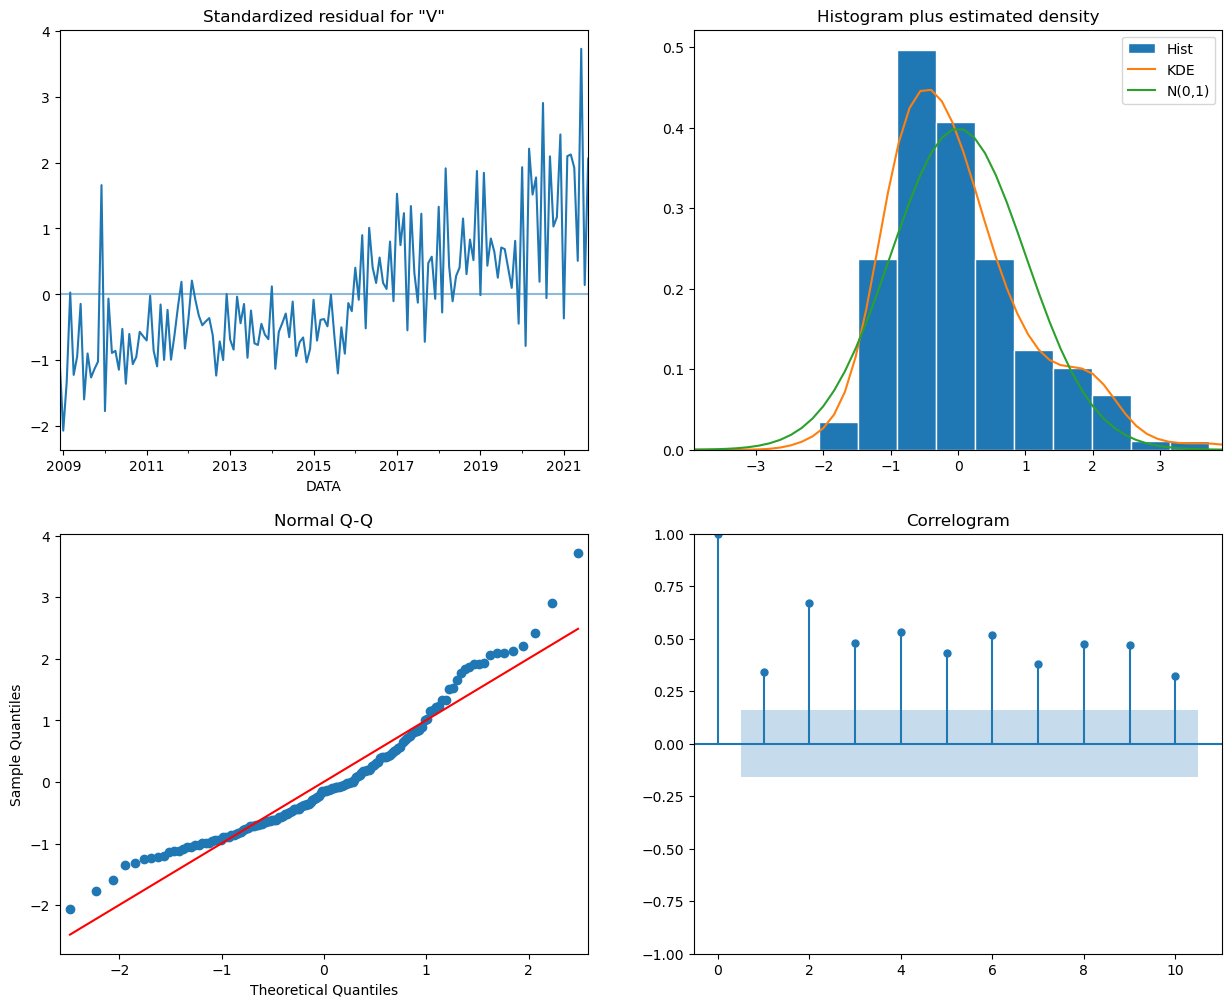

In [242]:
results_ARIMA_001.plot_diagnostics(figsize=(15, 12))
plt.show()

Plotar os resíduos, histograma , correlação com plot_diagnostic do modelo results_ARIMA_002 (0,0,2)

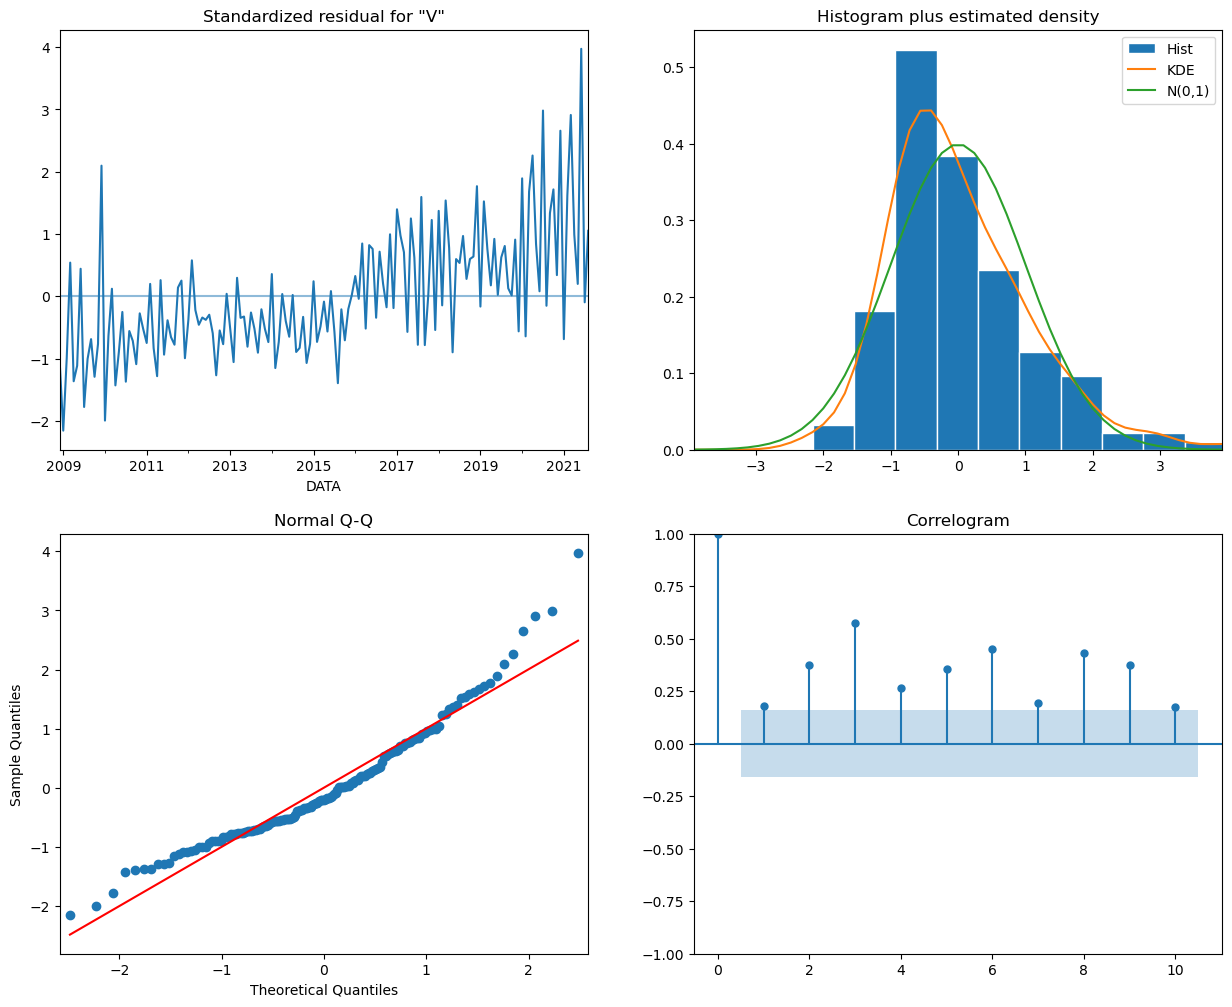

In [243]:
results_ARIMA_002.plot_diagnostics(figsize=(15, 12))
plt.show()

Plotar os resíduos, histograma , correlação com plot_diagnostic do modelo results_ARIMA_003 (1,1,1)

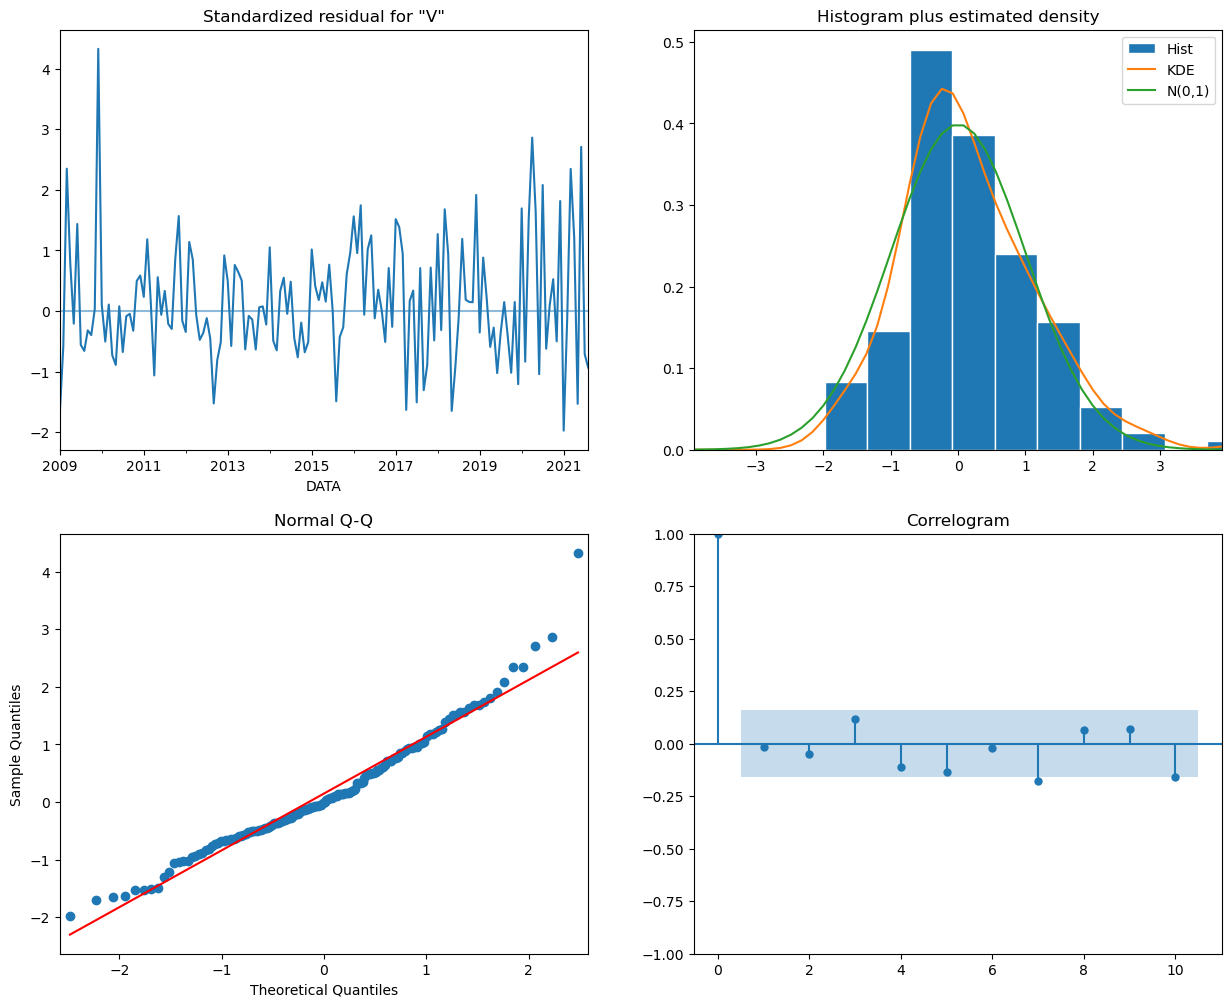

In [244]:
results_ARIMA_003.plot_diagnostics(figsize=(15, 12))
plt.show()

Plotar os resíduos, histograma , correlação com plot_diagnostic do modelo results_ARIMA_004 (1,1,2)

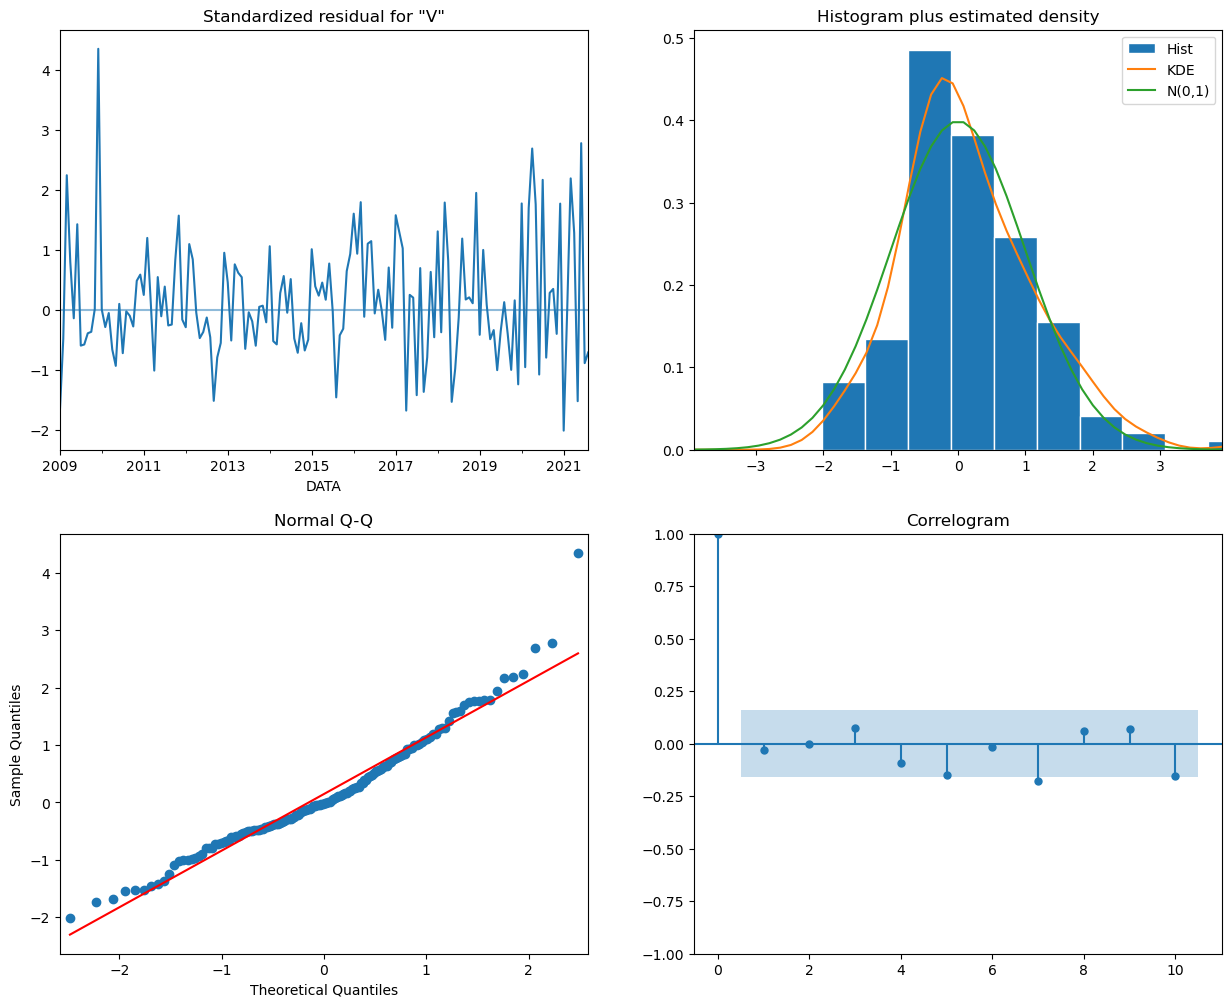

In [245]:
results_ARIMA_004.plot_diagnostics(figsize=(15, 12))
plt.show()

Verificamos pelos resultados que a configuração com ordem 1,1,2 os resultados parecem melhores

In [246]:
print("Resultado Modelo ARIMA 3 (1,1,1): ", results_ARIMA_003.fittedvalues)

Resultado Modelo ARIMA 3 (1,1,1):  DATA
2008-12-01       0.000000
2009-01-01    2006.502469
2009-02-01    1645.541895
2009-03-01    1574.771991
2009-04-01    1889.437532
                 ...     
2021-04-01    4017.102001
2021-05-01    4122.031353
2021-06-01    3930.738342
2021-07-01    4255.250498
2021-08-01    4139.136387
Freq: MS, Length: 153, dtype: float64


Observando as o modelo results_ARIMA_003 (1,1,1)

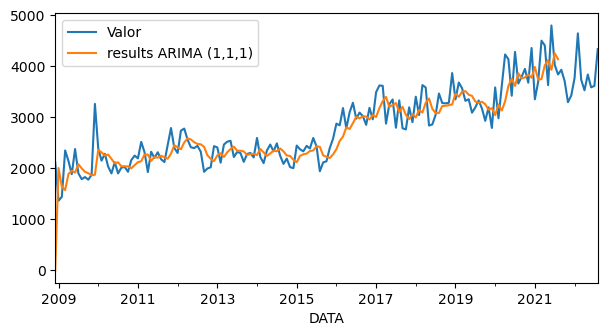

In [247]:
plt.figure(figsize = (7, 3.5))
df_vendas_ano['VALOR'].plot(label="Valor")
results_ARIMA_003.fittedvalues.plot(label="results ARIMA (1,1,1)");
plt.legend()

Adicionando colunas para armazenar os valores das diferenças com sazonalidade de 12 periodos

In [248]:
df_vendas_ano['VALOR First Difference'] = df_vendas_ano['VALOR'] - df_vendas_ano['VALOR'].shift(1)
df_vendas_ano['Seasonal First Difference']=df_vendas_ano['VALOR'] - df_vendas_ano['VALOR'].shift(12)

Comparação parâmetros teste adfuller serie original e com os valores de diferença de sazonalidade

In [249]:
print('Adfuller: ', adfuller_test(df_vendas_ano['VALOR']))
print('Adfuller Seasonal First Difference', adfuller_test(df_vendas_ano['Seasonal First Difference'].dropna()))

ADF Test Statistic : -0.6028292677250977
p-value : 0.8703414458458909
#Lags Used : 10
Number of Observations : 154
weak evidence against null hypothesis,indicating it is non-stationary 
Adfuller:  None
ADF Test Statistic : -3.9280085076567777
p-value : 0.0018381210679245447
#Lags Used : 12
Number of Observations : 140
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary
Adfuller Seasonal First Difference None


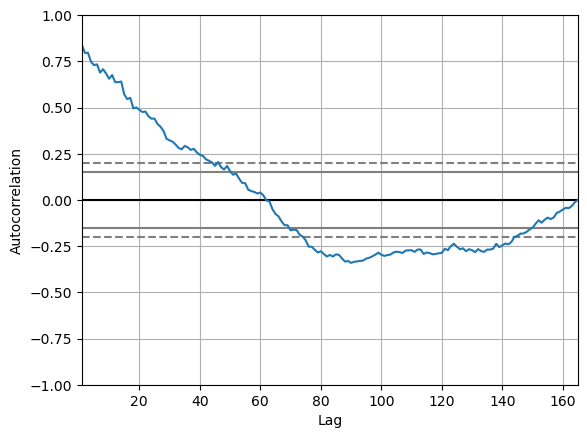

In [250]:
autocorrelation_plot(df_vendas_ano['VALOR'])
plt.show()

In [251]:
ARIMA_PREVISAO = results_ARIMA_003.predict(153, end = 164 ,dynamic=True)

Plot da previsão com modelo ARIMA que teve melhor desempenho 

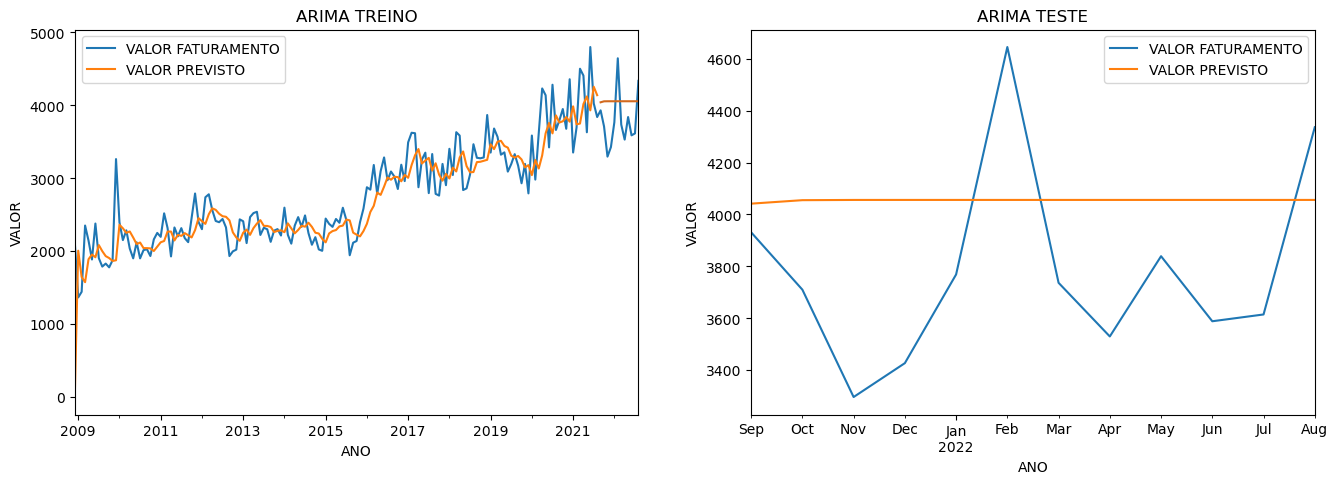

In [252]:
fig, axes = plt.subplots(1, 2,figsize = (16, 5))
df_vendas_ano['VALOR'].plot(ax = axes[0])
results_ARIMA_003.fittedvalues.plot(ax = axes[0]);
ARIMA_PREVISAO.plot(ax = axes[0], color = 'chocolate')
df_test['VALOR'].plot(ax = axes[1])
ARIMA_PREVISAO.plot(ax = axes[1])
axes[0].set_title('ARIMA TREINO')
axes[0].set_xlabel('ANO')
axes[0].set_ylabel('VALOR')
axes[0].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
axes[1].set_title('ARIMA TESTE')
axes[1].set_xlabel('ANO')
axes[1].set_ylabel('VALOR')
axes[1].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
#plt.savefig("../ARIMA.png", dpi = 600 )

Calculamos o desempenho com as métricas RMSE, MAPE, MAE para os 3 modelos

In [253]:
Metricas_(ARIMA_PREVISAO, df_test['VALOR'], 'ARIMA')

(11.21, 414.1969873099956, 451.8137274650495, 'ARIMA', 48655.4)

Inclusão dos resultados RMSE, MAPE e MAE do desempenho do modelo no dataframe df_Results

In [254]:
df_Results

,Model,RMSE,MAE,MAPE (%),Valor Anual (R$)
7,Tendência Linear,360.237172,288.427361,7.53,46094.24
6,Tendendia Quadratica,587.223601,535.343601,14.71,51034.10
5,Transformação Logarítmica,391.027824,342.893889,9.16,47394.84
4,Simple Smoothing 03,456.299725,420.013622,11.38,48752.43
3,Simple Smoothing 05,431.326468,391.123001,10.55,48232.39
2,Simple Smoothing 08,379.968126,316.668680,8.38,46798.41
1,Triple Exponential Smoothing,484.162208,434.768875,11.90,49364.80
0,ARIMA,451.813727,414.196987,11.21,48655.40


# 7 - SARIMA

Previsão com modelo SARIMA 

In [255]:
model_SARIMA=sm.tsa.statespace.SARIMAX(treino_ARIMA,order=(0, 1, 0),seasonal_order=(1,1,1,12))
results_SARIMA=model_SARIMA.fit()

Plot da previsão com modelo SARIMA

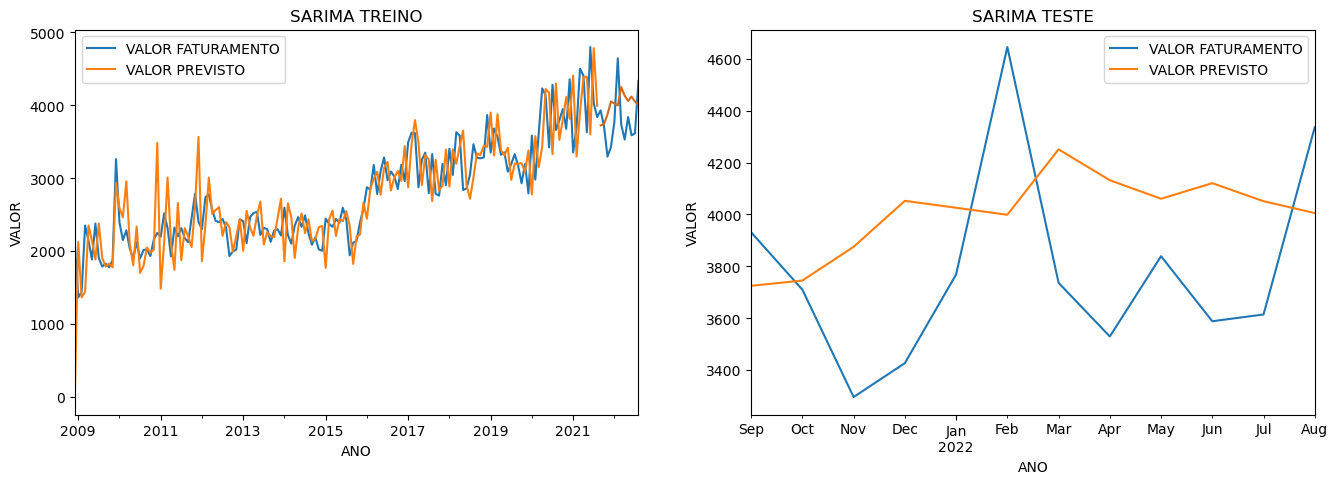

In [256]:
SARIMA_PREVISAO=results_SARIMA.predict(153, end = 164,dynamic=True)

fig, axes = plt.subplots(1, 2,figsize = (16, 5))
df_vendas_ano['VALOR'].plot(ax = axes[0])
results_SARIMA.fittedvalues.plot(ax = axes[0]);
SARIMA_PREVISAO.plot(ax = axes[0], color = 'chocolate')
df_test['VALOR'].plot(ax = axes[1])
SARIMA_PREVISAO.plot(ax = axes[1])
axes[0].set_title('SARIMA TREINO')
axes[0].set_xlabel('ANO')
axes[0].set_ylabel('VALOR')
axes[0].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
axes[1].set_title('SARIMA TESTE')
axes[1].set_xlabel('ANO')
axes[1].set_ylabel('VALOR')
axes[1].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
#plt.savefig("../SARIMA.png", dpi = 600 )

Criação de um novo dataframe para armazenar as previsões do modelo sarima

In [257]:
SARIMA_PREVISAO

2021-09-01    3725.097108
2021-10-01    3745.380886
2021-11-01    3875.259510
2021-12-01    4052.372711
2022-01-01    4025.751017
2022-02-01    3998.668407
2022-03-01    4250.672997
2022-04-01    4131.783934
2022-05-01    4060.444791
2022-06-01    4120.437191
2022-07-01    4050.965860
2022-08-01    4005.281507
Freq: MS, Name: predicted_mean, dtype: float64

Calculamos o desempenho com as métricas RMSE, MAPE, MAE para os 3 modelos

In [258]:
Metricas_(SARIMA_PREVISAO, df_test['VALOR'], 'SARIMA')

(11.15, 415.40356256521073, 457.4845088948787, 'SARIMA', 48042.12)

Inclusão dos resultados RMSE, MAPE e MAE do desempenho do modelo no dataframe df_Results

In [259]:
df_Results

,Model,RMSE,MAE,MAPE (%),Valor Anual (R$)
8,Tendência Linear,360.237172,288.427361,7.53,46094.24
7,Tendendia Quadratica,587.223601,535.343601,14.71,51034.10
6,Transformação Logarítmica,391.027824,342.893889,9.16,47394.84
5,Simple Smoothing 03,456.299725,420.013622,11.38,48752.43
4,Simple Smoothing 05,431.326468,391.123001,10.55,48232.39
3,Simple Smoothing 08,379.968126,316.668680,8.38,46798.41
2,Triple Exponential Smoothing,484.162208,434.768875,11.90,49364.80
1,ARIMA,451.813727,414.196987,11.21,48655.40
0,SARIMA,457.484509,415.403563,11.15,48042.12


# 8 - Prophet

Criando um novo dataframe e definindo a coluna data como ds e a coluna target como y

In [260]:
df_prophet = pd.DataFrame({'ds':df_vendas_ano.index, 'y':df_vendas_ano.VALOR})

Fazendo um filtro para separar o treino do teste

In [261]:
filtro0 = df_prophet.index > '2021-08-01'
df_prophet_2022 = df_prophet.loc[filtro0]
filtro0 = df_prophet.index < '2021-09-01'
df_prophet_2021 = df_prophet.loc[filtro0]

validação_prophet é o nosso test para verificação do modelo

In [262]:
validação_prophet = pd.DatetimeIndex(df_prophet_2022['ds'],freq='MS')
validação_prophet
teste_prophet = pd.DatetimeIndex(df_prophet_2021['ds'],freq='MS')

Definindo a função RandomizedSearchCV para a pesquisa dos melhores parametros para o meu modelo Prophet

In [263]:
parametro = {
    'seasonality_mode':['multiplicative','additive'],
    'n_changepoints':[True,False],
    'changepoint_prior_scale': [0.01,0.015],
    'seasonality_prior_scale': [0.01,0.015],
    'yearly_seasonality':[True,False],
    'holidays_prior_scale':[0.1,0.5, 1, 5],
    'weekly_seasonality':[False],
    'daily_seasonality':[False]
}  
fh = validação_prophet


Utilizando a função ForecastingRandomizedSearchCV

In [264]:
cv = ExpandingWindowSplitter(
    initial_window=9,
    step_length=12,
    start_with_window=True,
    
)
forecaster = Prophet()
gscv = ForecastingRandomizedSearchCV(
    verbose = 1,
    n_jobs = -1,
    forecaster=forecaster,
    param_distributions=parametro,
    cv=cv)
prophet_treino = gscv.fit(df_prophet_2021['y'], fh=fh)
y_pred = gscv.predict(fh)

Fitting 12 folds for each of 10 candidates, totalling 120 fits


prophet.models WARNING Optimization terminated abnormally. Falling back to Newton.
prophet.models WARNING Optimization terminated abnormally. Falling back to Newton.


criando um dataframe com a previsão do treino

In [265]:
x_pred = gscv.predict(teste_prophet)

Olhando os melhores paramentros encontrados

In [266]:
print(gscv.best_params_)

{'yearly_seasonality': True, 'weekly_seasonality': False, 'seasonality_prior_scale': 0.015, 'seasonality_mode': 'additive', 'n_changepoints': False, 'holidays_prior_scale': 1, 'daily_seasonality': False, 'changepoint_prior_scale': 0.015}


Verificando os valores preditos pelo modelo

In [267]:
y_pred

2021-09-01    3598.076427
2021-10-01    3617.647569
2021-11-01    3728.318435
2021-12-01    3884.605890
2022-01-01    3851.502046
2022-02-01    3823.154350
2022-03-01    4047.187558
2022-04-01    3943.081917
2022-05-01    3885.273261
2022-06-01    3949.132789
2022-07-01    3894.078128
2022-08-01    3859.769090
dtype: float64

Plotando no grafico o valor real em azul e a previsão em vermelho

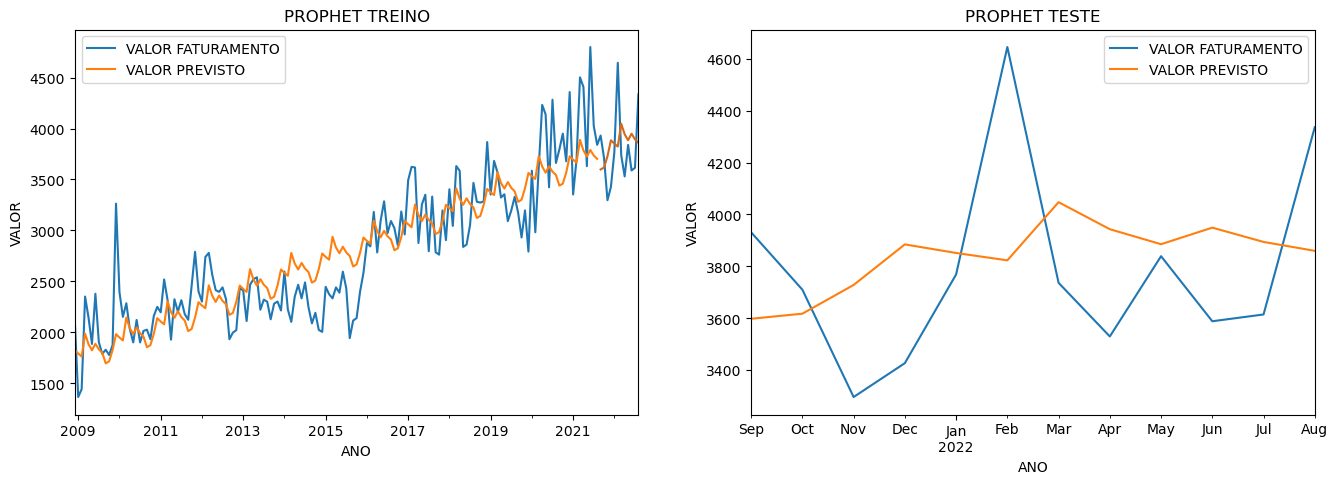

In [268]:
fig, axes = plt.subplots(1, 2,figsize = (16, 5))
df_vendas_ano['VALOR'].plot(ax = axes[0])
x_pred.plot(ax = axes[0])
y_pred.plot(ax = axes[0], color = 'chocolate')
df_test['VALOR'].plot(ax = axes[1])
y_pred.plot(ax = axes[1])
axes[0].set_title('PROPHET TREINO')
axes[0].set_xlabel('ANO')
axes[0].set_ylabel('VALOR')
axes[0].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
axes[1].set_title('PROPHET TESTE')
axes[1].set_xlabel('ANO')
axes[1].set_ylabel('VALOR')
axes[1].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
#plt.savefig("../PROPHET.png", dpi = 600 )

Calculamos o desempenho com as métricas RMSE, MAPE, MAE

In [269]:
Metricas_(y_pred, df_test['VALOR'], 'Prophet')

(8.94, 342.1331856750057, 398.0815395594795, 'Prophet', 46081.83)

Inclusão dos resultados RMSE, MAPE e MAE do desempenho do modelo no dataframe df_Results

In [270]:
df_Results

,Model,RMSE,MAE,MAPE (%),Valor Anual (R$)
9,Tendência Linear,360.237172,288.427361,7.53,46094.24
8,Tendendia Quadratica,587.223601,535.343601,14.71,51034.10
7,Transformação Logarítmica,391.027824,342.893889,9.16,47394.84
6,Simple Smoothing 03,456.299725,420.013622,11.38,48752.43
5,Simple Smoothing 05,431.326468,391.123001,10.55,48232.39
4,Simple Smoothing 08,379.968126,316.668680,8.38,46798.41
3,Triple Exponential Smoothing,484.162208,434.768875,11.90,49364.80
2,ARIMA,451.813727,414.196987,11.21,48655.40
1,SARIMA,457.484509,415.403563,11.15,48042.12
0,Prophet,398.081540,342.133186,8.94,46081.83


# 9 - Xgboost

Definindo um novo dataframe para o modelo XGBoost e deixando somente a coluna valor

In [271]:
df_xgboost = pd.DataFrame({'Datetime':df_vendas_ano.index, 'VALOR':df_vendas_ano.VALOR})
df_xgboost.drop('Datetime', axis = 1, inplace = True)

Separando meu conjunto de treino, validação e test

In [272]:
end_train = '2021-08-01'
end_validation = '2022-08-01'
data_train = df_xgboost.loc[: end_train, :]
data_val   = df_xgboost.loc[end_train:end_validation, :]
data_test  = df_xgboost.loc[end_validation:, :]
dxg_train, dxg_test = train_test_split(df_xgboost, test_size = 12, random_state = 42, shuffle = False)

Plot do meu dados de treino e de test

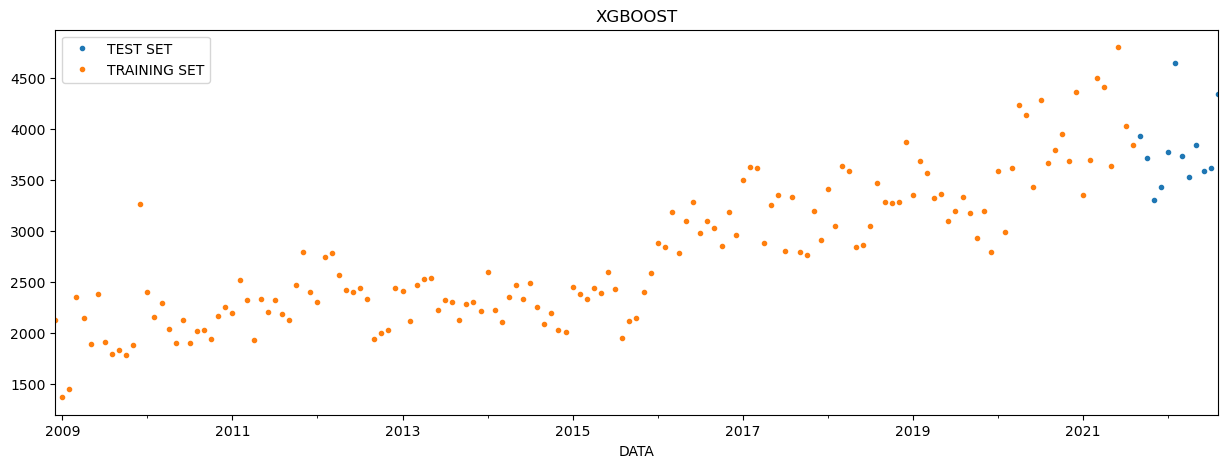

In [273]:
_ = dxg_test \
    .rename(columns={'VALOR': 'TEST SET'}) \
    .join(dxg_train.rename(columns={'VALOR': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='XGBOOST', style='.')

Função que cria mais features baseados em epocas

In [274]:
def create_features(df_xgboost, label=None):
    df_xgboost['date'] = df_xgboost.index
    df_xgboost['dayofweek'] = df_xgboost['date'].dt.dayofweek
    df_xgboost['quarter'] = df_xgboost['date'].dt.quarter
    df_xgboost['month'] = df_xgboost['date'].dt.month
    df_xgboost['year'] = df_xgboost['date'].dt.year
    df_xgboost['dayofyear'] = df_xgboost['date'].dt.dayofyear
    df_xgboost['dayofmonth'] = df_xgboost['date'].dt.day
    df_xgboost['weekofyear'] = df_xgboost['date'].dt.weekofyear
    
    X = df_xgboost[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df_xgboost[label]
        return X, y
    return X

In [275]:
dxgb_train, dygb_train = create_features(dxg_train, label='VALOR')
dxgb_test, dygb_test = create_features(dxg_test, label='VALOR')

Trazendos os melhores paramentros encontrados

In [276]:
forecaster  =  ForecasterAutoreg ( 
                regressor  =  XGBRegressor ( random_state = 42 ), 
                lags  =  153 
                )

forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=42,
             reg_alpha=None, reg_lambda=None, ...) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58

Aplicandos os paramentros e executando o Grid Search

In [277]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100,300,500],
    'max_depth': [3,4,5],
    'learning_rate': [0.01,0.015]
    }

# Lags used as predictors
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]


results_grid = grid_search_forecaster(
        forecaster         = forecaster,
        y                  = df_xgboost.loc[:end_validation, 'VALOR'], # Train and validation data
        param_grid         = param_grid,
        lags_grid          = lags_grid,
        steps              = 36,
        refit              = False,
        metric             = 'mean_absolute_percentage_error',
        initial_train_size = int(len(data_train)), # Model is trained with trainign data
        #fixed_train_size   = False,
        return_best        = True,
        verbose            = False
        )

Number of models compared: 72.


loop lags_grid: 100%|███████████████████████████████████████| 4/4 [00:22<00:00,  5.66s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.015, 'max_depth': 4, 'n_estimators': 300}
  Backtesting metric: 0.06455005236800769



Colocandos os melhores Hyperparamentros encontrados

In [278]:
reg = xgb.XGBRegressor(n_estimators=500, max_depth = 3, learning_rate = 0.015)
reg.fit(dxgb_train, dygb_train,
        eval_set=[(dxgb_train, dygb_train), (dxgb_test, dygb_test)],
        early_stopping_rounds=30,
       verbose=False) # Change verbose to True if you want to see it train


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.015, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

Plot das features mais importantes

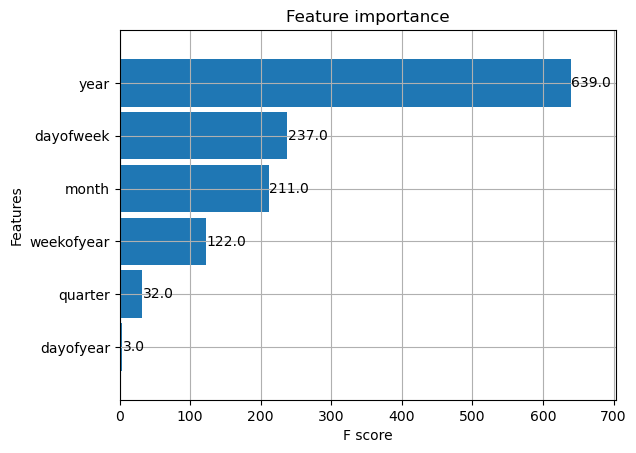

In [279]:
_ = plot_importance(reg, height=0.9)

fazendo o predict do modelo e mostrandos os valores

In [280]:
dxg_test['XGB_Prediction'] = reg.predict(dxgb_test)
dxg_train['XGB_Train'] = reg.predict(dxgb_train)
xgboost = dxg_test['XGB_Prediction']

Plot da previsão do modelo e do valor real

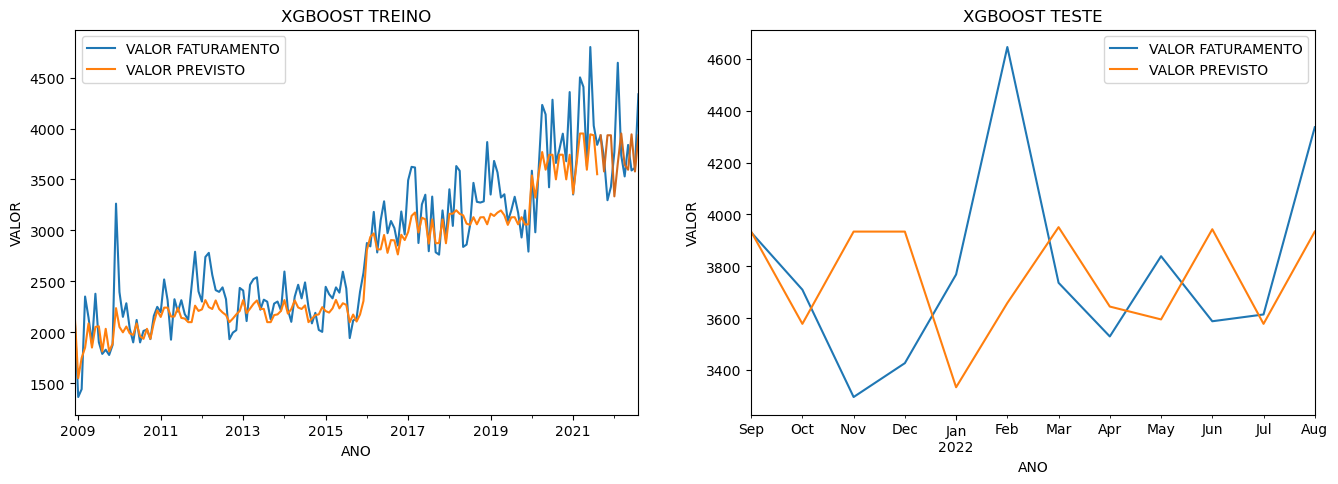

In [281]:
fig, axes = plt.subplots(1, 2,figsize = (16, 5))
df_vendas_ano['VALOR'].plot(ax = axes[0])
dxg_train['XGB_Train'].plot(ax = axes[0])
xgboost.plot(ax = axes[0], color = 'chocolate')
df_test['VALOR'].plot(ax = axes[1])
xgboost.plot(ax = axes[1])
axes[0].set_title('XGBOOST TREINO')
axes[0].set_xlabel('ANO')
axes[0].set_ylabel('VALOR')
axes[0].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
axes[1].set_title('XGBOOST TESTE')
axes[1].set_xlabel('ANO')
axes[1].set_ylabel('VALOR')
axes[1].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
#plt.savefig("../XGBOOST.png", dpi = 600 )

Calculamos o desempenho com as métricas RMSE, MAPE, MAE

In [282]:
Metricas_(dxg_test['XGB_Prediction'], df_test['VALOR'], 'XGBoost')

(8.83, 338.74637868648125, 432.8866464972231, 'XGBoost', 45020.14)

Inclusão dos resultados RMSE, MAPE e MAE do desempenho do modelo no dataframe df_Results

In [283]:
df_Results

,Model,RMSE,MAE,MAPE (%),Valor Anual (R$)
10,Tendência Linear,360.237172,288.427361,7.53,46094.240000
9,Tendendia Quadratica,587.223601,535.343601,14.71,51034.100000
8,Transformação Logarítmica,391.027824,342.893889,9.16,47394.840000
7,Simple Smoothing 03,456.299725,420.013622,11.38,48752.430000
6,Simple Smoothing 05,431.326468,391.123001,10.55,48232.390000
5,Simple Smoothing 08,379.968126,316.668680,8.38,46798.410000
4,Triple Exponential Smoothing,484.162208,434.768875,11.90,49364.800000
3,ARIMA,451.813727,414.196987,11.21,48655.400000
2,SARIMA,457.484509,415.403563,11.15,48042.120000
1,Prophet,398.081540,342.133186,8.94,46081.830000


# 10 - LSTM Rede Neural Profunda

Criando o dataframe para o modelo LSTM

In [284]:
df_LSTM = df_prophet.drop('ds',axis=1)

Aplicando um filtro considerando as datas a partir de 2009/09/01 para afim de termos ciclos de 12 meses

In [285]:
filtro1 = df_LSTM.index >= '2009-09-01'
filtro1
df_LSTM_2011 = df_LSTM.loc[filtro1]
df_LSTM_2011.index

DatetimeIndex(['2009-09-01', '2009-10-01', '2009-11-01', '2009-12-01',
               '2010-01-01', '2010-02-01', '2010-03-01', '2010-04-01',
               '2010-05-01', '2010-06-01',
               ...
               '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01'],
              dtype='datetime64[ns]', name='DATA', length=156, freq='MS')

Vamos agora separar os dados de treino e teste

In [286]:
data=df_LSTM_2011.filter(['y'])
dataset=data.values
training_data_len=math.ceil(len(dataset)-12)
training_data_len_2=math.ceil(len(dataset))

Alterando a escala dos dados de 0 a 1

In [287]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

Separando as bases de treino e teste

Separando o treino para verificar a quantidade de epocas pelo gráfico

In [288]:
train_data_2 = scaled_data[0:training_data_len_2,:]
x_train_2=[]
y_train_2=[]

for i in range(12,len(train_data_2)):
  x_train_2.append(train_data_2[i-12:i,0])
  y_train_2.append(train_data_2[i,0])
  if i<=12:
    print(x_train_2)
    print(y_train_2)
    print()

[array([0.01706009, 0.        , 0.03227858, 0.49141138, 0.20420373,
       0.123707  , 0.1679806 , 0.08521258, 0.04080805, 0.11370636,
       0.04075008, 0.07819223])]
[0.08220934630966592]



convertendo x_train e y_train para um array numpy

In [289]:
x_train_2,y_train_2 = np.array(x_train_2), np.array(y_train_2)

Redimensionamento dos dados

In [290]:
x_train_2=np.reshape(x_train_2, (x_train_2.shape[0], x_train_2.shape[1],1))

Criando a base de teste

In [291]:
test_data=scaled_data[training_data_len-12:,:]
x_test=[]
y_test=dataset[training_data_len:,:]

for i in range(12,len(test_data)):
  x_test.append(test_data[i-12:i,0])

x_test=np.array(x_test)
x_test=np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

Criando o modelo de rede neural com 3 camadas

In [292]:
model=Sequential()
model.add(LSTM(10, return_sequences=True, input_shape=(x_train_2.shape[1],1)))
model.add(LSTM(10, return_sequences=True))
model.add(LSTM(10, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

Compilando o modelo

In [293]:
model.compile(optimizer=Adam(learning_rate=0.005), loss = 'mean_absolute_error', metrics = [RootMeanSquaredError()])

Epoch 1/100
6/6 [==============================] - 6s 266ms/step - loss: 0.2698 - root_mean_squared_error: 0.3469 - val_loss: 0.2339 - val_root_mean_squared_error: 0.2632
Epoch 2/100
6/6 [==============================] - 0s 22ms/step - loss: 0.1876 - root_mean_squared_error: 0.2185 - val_loss: 0.1976 - val_root_mean_squared_error: 0.2321
Epoch 3/100
6/6 [==============================] - 0s 21ms/step - loss: 0.1479 - root_mean_squared_error: 0.1891 - val_loss: 0.2204 - val_root_mean_squared_error: 0.2528
Epoch 4/100
6/6 [==============================] - 0s 28ms/step - loss: 0.1135 - root_mean_squared_error: 0.1444 - val_loss: 0.1773 - val_root_mean_squared_error: 0.1904
Epoch 5/100
6/6 [==============================] - 0s 23ms/step - loss: 0.1044 - root_mean_squared_error: 0.1352 - val_loss: 0.1553 - val_root_mean_squared_error: 0.1675
Epoch 6/100
6/6 [==============================] - 0s 23ms/step - loss: 0.1061 - root_mean_squared_error: 0.1281 - val_loss: 0.1030 - val_root_mean_s

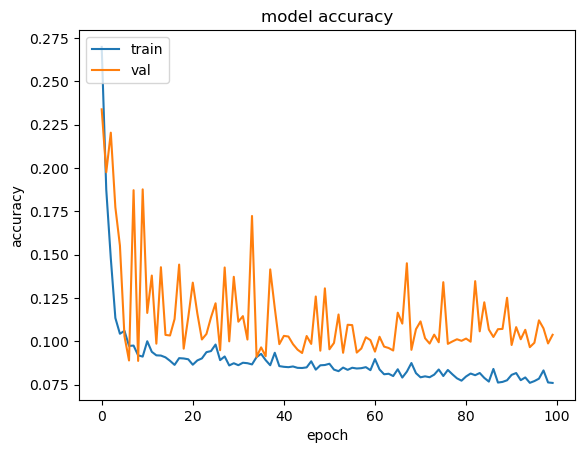

In [294]:
history = model.fit(x_train_2, y_train_2,validation_split=0.0833 , epochs=100, batch_size=24)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [295]:
model.compile(optimizer=Adam(learning_rate=0.005), loss = 'mean_absolute_error', metrics = [RootMeanSquaredError()])

Fazendo o fit do modelo e foram escolhidos 20 epocas baseado no plot anterior

In [296]:
model.fit(x_train_2,x_train_2,batch_size=24,epochs=60)

Epoch 1/60
6/6 [==============================] - 4s 11ms/step - loss: 0.0813 - root_mean_squared_error: 0.1076
Epoch 2/60
6/6 [==============================] - 0s 10ms/step - loss: 0.0772 - root_mean_squared_error: 0.1013
Epoch 3/60
6/6 [==============================] - 0s 9ms/step - loss: 0.0754 - root_mean_squared_error: 0.0989
Epoch 4/60
6/6 [==============================] - 0s 11ms/step - loss: 0.0743 - root_mean_squared_error: 0.0971
Epoch 5/60
6/6 [==============================] - 0s 9ms/step - loss: 0.0741 - root_mean_squared_error: 0.0974
Epoch 6/60
6/6 [==============================] - 0s 10ms/step - loss: 0.0747 - root_mean_squared_error: 0.0973
Epoch 7/60
6/6 [==============================] - 0s 9ms/step - loss: 0.0743 - root_mean_squared_error: 0.0973
Epoch 8/60
6/6 [==============================] - 0s 9ms/step - loss: 0.0739 - root_mean_squared_error: 0.0969
Epoch 9/60
6/6 [==============================] - 0s 10ms/step - loss: 0.0735 - root_mean_squared_error: 0.0

In [297]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 12, 10)            480       
                                                                 
 lstm_4 (LSTM)               (None, 12, 10)            840       
                                                                 
 lstm_5 (LSTM)               (None, 10)                840       
                                                                 
 dense_2 (Dense)             (None, 25)                275       
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 2,461
Trainable params: 2,461
Non-trainable params: 0
_________________________________________________________________


Gerando as previsões, invertendo a escala e mostrando os valores

In [298]:
treino_pred = model.predict(x_train_2)
treino_pred = scaler.inverse_transform(treino_pred)

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


predictions

1/1 [==============================] - 0s 10ms/step


array([[3894.8806],
       [3901.7432],
       [3893.6511],
       [3872.1628],
       [3819.5664],
       [3832.2415],
       [3870.4146],
       [3838.8762],
       [3786.5996],
       [3783.8118],
       [3720.1384],
       [3697.774 ]], dtype=float32)

Calculamos o desempenho com as métricas RMSE, MAPE, MAE

In [299]:
Metricas_(predictions, y_test, 'LSTM')

(7.7299999999999995, 297.32006453896093, 390.3395644703906, 'LSTM', 45911.86)

Inclusão dos resultados RMSE, MAPE e MAE do desempenho do modelo no dataframe df_Results

In [300]:
df_Results

,Model,RMSE,MAE,MAPE (%),Valor Anual (R$)
11,Tendência Linear,360.237172,288.427361,7.53,46094.240000
10,Tendendia Quadratica,587.223601,535.343601,14.71,51034.100000
9,Transformação Logarítmica,391.027824,342.893889,9.16,47394.840000
8,Simple Smoothing 03,456.299725,420.013622,11.38,48752.430000
7,Simple Smoothing 05,431.326468,391.123001,10.55,48232.390000
6,Simple Smoothing 08,379.968126,316.668680,8.38,46798.410000
5,Triple Exponential Smoothing,484.162208,434.768875,11.90,49364.800000
4,ARIMA,451.813727,414.196987,11.21,48655.400000
3,SARIMA,457.484509,415.403563,11.15,48042.120000
2,Prophet,398.081540,342.133186,8.94,46081.830000


Separando os dados para plotagem

In [301]:
train=data[:training_data_len]
valid=data[training_data_len:]
valid['Predictions'] = predictions
train['Predictions'] = treino_pred

Plotando a previsão de faturamento e o valor real

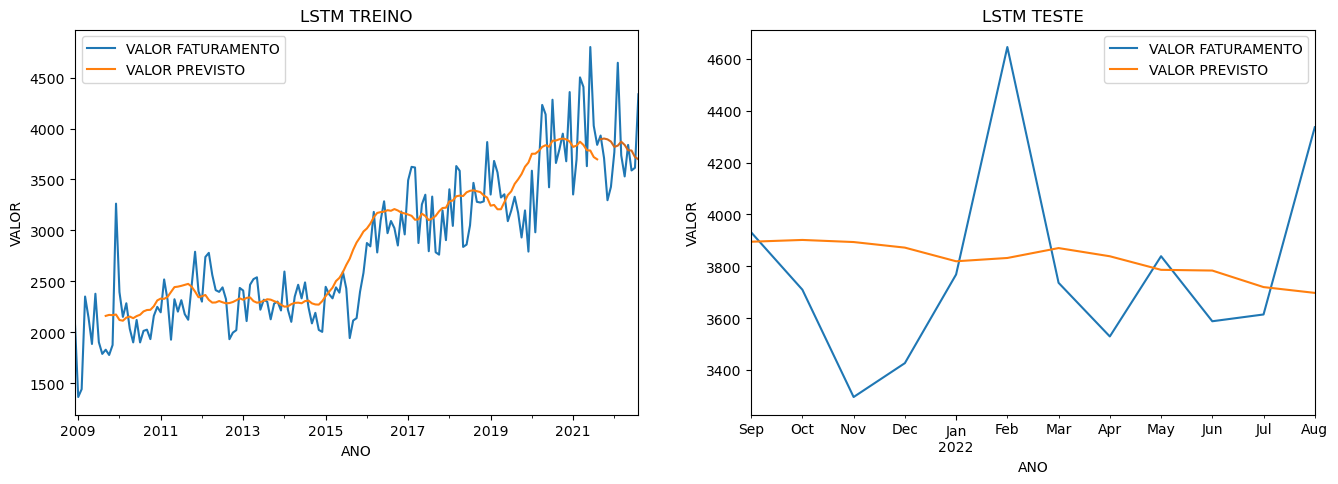

In [302]:
fig, axes = plt.subplots(1, 2,figsize = (16, 5))
df_vendas_ano['VALOR'].plot(ax = axes[0])
train['Predictions'].plot(ax = axes[0])
valid['Predictions'].plot(ax = axes[0], color = 'chocolate')
df_test['VALOR'].plot(ax = axes[1])
valid['Predictions'].plot(ax = axes[1])
axes[0].set_title('LSTM TREINO')
axes[0].set_xlabel('ANO')
axes[0].set_ylabel('VALOR')
axes[0].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
axes[1].set_title('LSTM TESTE')
axes[1].set_xlabel('ANO')
axes[1].set_ylabel('VALOR')
axes[1].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
#plt.savefig("../LSTM.png", dpi = 600 )

# 11 ENSEMBLE

Criação do dataframe Ensemble com a combinação dos resultados de todos os modelos.

In [303]:
df_ensemble = df_test.drop(columns=['DATAINDEX', 'DATAINDEX_SQ','LOG_VALOR', 'LOG_TREND'])

Adicionando os resultados dos modelos no dataframe

In [304]:
df_ensemble = pd.concat([df_ensemble, df_linear], axis=1)
df_ensemble.rename(columns={0: 'Tendência Linear'}, inplace=True)
df_ensemble = pd.concat([df_ensemble, SARIMA_PREVISAO], axis=1)
df_ensemble.rename(columns={'predicted_mean':'Sarima'}, inplace=True)
df_ensemble = pd.concat([df_ensemble, y_pred], axis=1)
df_ensemble.rename(columns={0:'Prophet'}, inplace=True)
df_ensemble = pd.concat([df_ensemble, predictions_hw], axis=1)
df_ensemble.rename(columns={'HW':'Tri Exp Smoothing'}, inplace=True)
df_ensemble.rename(columns={'QUADRATIC_TEND':'Tend Quadrática'}, inplace=True)
df_ensemble.rename(columns={'BACK_LOG_TREND':'Trans Logarítmica'}, inplace=True)
df_ensemble['LSTM'] = predictions
df_ensemble['XGBoost'] = xgboost
df_ensemble

,VALOR,Tend Quadrática,Trans Logarítmica,Simple Smoothing 03,Simple Smoothing 05,Simple Smoothing 08,Tendência Linear,Sarima,Prophet,Tri Exp Smoothing,LSTM,XGBoost
2021-09-01,3931.137219,4105.118059,3847.533188,4062.702128,4019.366197,3899.867213,3768.661924,3725.097108,3598.076427,4118.586382,3894.880615,3933.901123
2021-10-01,3710.122383,4131.413090,3865.793400,4062.702128,4019.366197,3899.867213,3781.848274,3745.380886,3617.647569,4065.876084,3901.743164,3578.462402
2021-11-01,3296.592830,4157.877265,3884.140274,4062.702128,4019.366197,3899.867213,3795.034624,3875.259510,3728.318435,4246.375578,3893.651123,3933.901123
2021-12-01,3427.125288,4184.510584,3902.574221,4062.702128,4019.366197,3899.867213,3808.220975,4052.372711,3884.605890,4044.467172,3872.162842,3933.901123
2022-01-01,3768.733612,4211.313048,3921.095654,4062.702128,4019.366197,3899.867213,3821.407325,4025.751017,3851.502046,4164.651882,3819.566406,3334.162354
2022-02-01,4644.960285,4238.284656,3939.704990,4062.702128,4019.366197,3899.867213,3834.593675,3998.668407,3823.154350,4292.044742,3832.241455,3658.888672
2022-03-01,3736.601278,4265.425408,3958.402645,4062.702128,4019.366197,3899.867213,3847.780025,4250.672997,4047.187558,4222.585035,3870.414551,3950.959473
2022-04-01,3529.909354,4292.735304,3977.189037,4062.702128,4019.366197,3899.867213,3860.966376,4131.783934,3943.081917,3820.033934,3838.876221,3645.076660
2022-05-01,3839.075501,4320.214345,3996.064590,4062.702128,4019.366197,3899.867213,3874.152726,4060.444791,3885.273261,3984.433521,3786.599609,3595.532715
2022-06-01,3588.479445,4347.862530,4015.029724,4062.702128,4019.366197,3899.867213,3887.339076,4120.437191,3949.132789,4185.993312,3783.811768,3942.989014


Escolhendo os modelos que tiveram os melhores resultados e agrupando pela média.

In [305]:
df_ensemble["Ensemble"] = df_ensemble[['Tendência Linear','LSTM','Simple Smoothing 08','Trans Logarítmica','Prophet','XGBoost']].mean(axis=1)

Plot do modelo ensemble

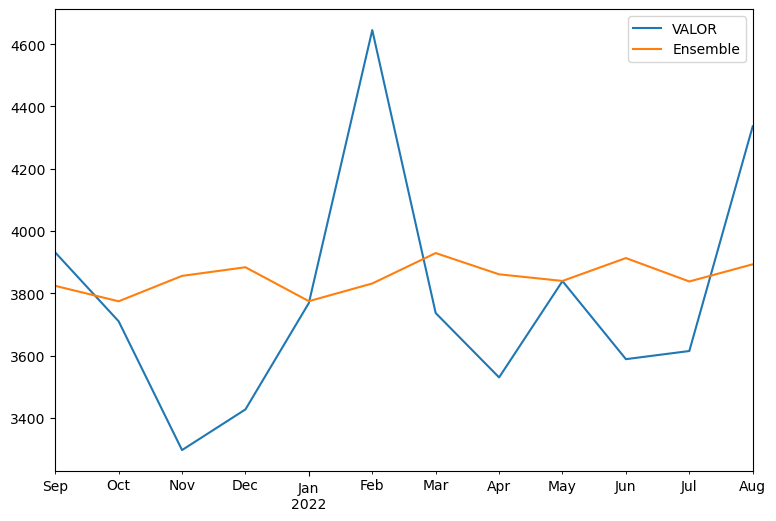

In [306]:
df_ensemble.VALOR.plot(figsize = (9,6), legend = True)
df_ensemble.Ensemble.plot(legend = True)
#plt.savefig("Ensemble.pdf")
plt.show()

Criando um ensemble dos modelos de treino

In [307]:
df_ensemble_train = df_train.drop(columns=['DATAINDEX', 'DATAINDEX_SQ','LOG_VALOR', 'LOG_TREND'])
df_ensemble_train = pd.concat([df_ensemble_train, df_linear_train], axis=1)
df_ensemble_train.rename(columns={0: 'Tendência Linear'}, inplace=True)
df_ensemble_train = pd.concat([df_ensemble_train, model_exp_smoothing_08.fittedvalues], axis=1)
df_ensemble_train.rename(columns={0:'Simple Smoothing 08'}, inplace=True)
df_ensemble_train = pd.concat([df_ensemble_train, treino_hw], axis=1)
df_ensemble_train.rename(columns={0:'Triple Exp Smoothing'}, inplace=True)
df_ensemble_train = pd.concat([df_ensemble_train, results_ARIMA_003.fittedvalues], axis=1)
df_ensemble_train.rename(columns={0:'ARIMA'}, inplace=True)
df_ensemble_train = pd.concat([df_ensemble_train, results_SARIMA.fittedvalues], axis=1)
df_ensemble_train.rename(columns={0:'SARIMA'}, inplace=True)
df_ensemble_train = pd.concat([df_ensemble_train, x_pred], axis=1)
df_ensemble_train.rename(columns={0:'Prophet'}, inplace=True)
df_ensemble_train = pd.concat([df_ensemble_train, dxg_train['XGB_Train']], axis=1)
df_ensemble_train = pd.concat([df_ensemble_train, train['Predictions']], axis=1)
df_ensemble_train.rename(columns={'LinearTrend':'Tendência Linear'}, inplace=True)
df_ensemble_train.rename(columns={'XGB_Train':'XGBoost'}, inplace=True)
df_ensemble_train.rename(columns={'Predictions':'LSTM'}, inplace=True)
df_ensemble_train.rename(columns={'QUADRATIC_TEND':'Tend Quadrática'}, inplace=True)
df_ensemble_train.rename(columns={'BACK_LOG_TREND':'Trans Logarítmica'}, inplace=True)
df_ensemble_train

,VALOR,Tend Quadrática,Trans Logarítmica,Tendência Linear,Simple Smoothing 08,Triple Exp Smoothing,ARIMA,SARIMA,Prophet,XGBoost,LSTM
2008-12-01,2124.826051,2074.666936,1864.548749,1751.150337,2124.826051,2532.103302,0.000000,0.000000,1825.596606,2161.632568,NaN
2009-01-01,1365.677737,2075.082894,1873.397809,1764.336687,2124.826051,2154.164254,2006.502469,2124.826051,1792.734479,1550.656128,NaN
2009-02-01,1442.712601,2075.667996,1882.288867,1777.523037,1517.507400,1945.873400,1645.541895,1365.677737,1763.193983,1749.229370,NaN
2009-03-01,2351.546014,2076.422243,1891.222122,1790.709388,1457.671561,1893.743275,1574.771991,1442.712601,1986.338363,1850.048340,NaN
2009-04-01,2144.901965,2077.345634,1900.197773,1803.895738,2172.771123,1991.863309,1889.437532,2351.546014,1883.441494,2087.693604,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2021-04-01,4408.051057,3976.180069,3757.517802,3702.730173,4334.031032,4061.494781,4017.102001,4379.129723,3785.423860,3950.959473,3838.876221
2021-05-01,3630.518542,4001.629378,3775.350805,3715.916523,4393.247052,4014.045896,4122.031353,4393.470502,3725.900413,3595.532715,3786.599609
2021-06-01,4799.527276,4027.247832,3793.268442,3729.102873,3783.064244,4533.728698,3930.738342,3603.466366,3789.646389,3942.989014,3783.811768
2021-07-01,4026.993576,4053.035430,3811.271116,3742.289223,4596.234670,4065.528534,4255.250498,4784.109245,3735.567688,3933.901123,3720.138428


In [308]:
df_ensemble_train["Ensemble"] = df_ensemble_train[['Tendência Linear','LSTM','Simple Smoothing 08','Trans Logarítmica','Prophet','XGBoost']].mean(axis=1)

Plot do Ensemble treino e teste

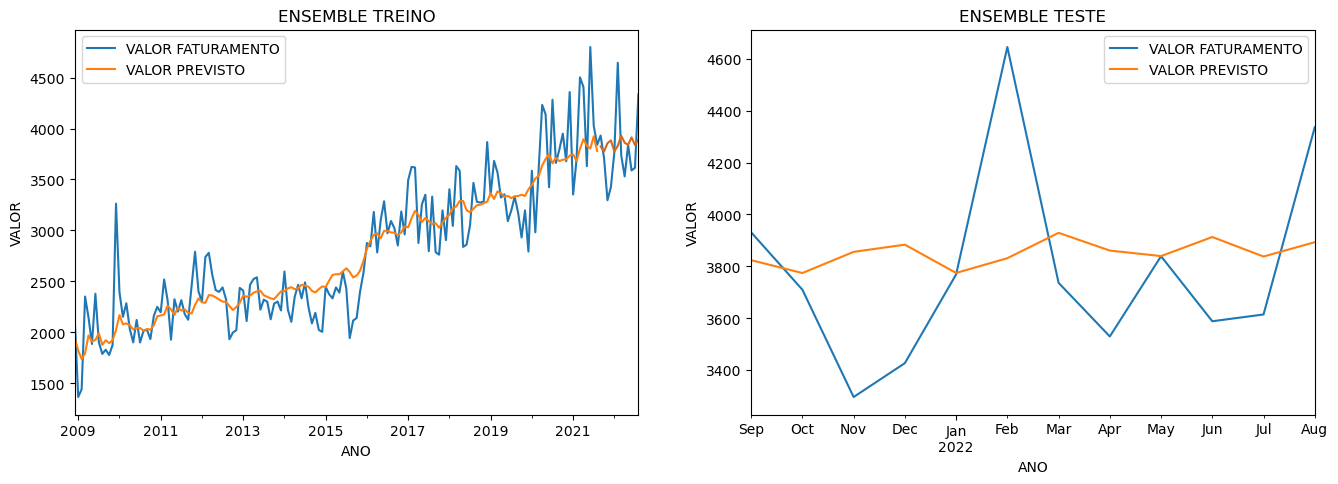

In [309]:
fig, axes = plt.subplots(1, 2,figsize = (16, 5))
df_vendas_ano['VALOR'].plot(ax = axes[0])
df_ensemble_train["Ensemble"].plot(ax = axes[0])
df_ensemble["Ensemble"].plot(ax = axes[0], color = 'chocolate')
df_test['VALOR'].plot(ax = axes[1])
df_ensemble["Ensemble"].plot(ax = axes[1])
axes[0].set_title('ENSEMBLE TREINO')
axes[0].set_xlabel('ANO')
axes[0].set_ylabel('VALOR')
axes[0].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
axes[1].set_title('ENSEMBLE TESTE')
axes[1].set_xlabel('ANO')
axes[1].set_ylabel('VALOR')
axes[1].legend(['VALOR FATURAMENTO','VALOR PREVISTO'])
plt.savefig("../ENSEMBLE.png", dpi = 600 )

Calculamos o desempenho com as métricas RMSE, MAPE, MAE

In [310]:
Metricas_(df_ensemble["Ensemble"], df_test['VALOR'], 'Ensemble')

(7.7, 293.4304716829089, 376.00145039969317, 'Ensemble', 46216.89)

Inclusão dos resultados RMSE, MAPE e MAE do desempenho do modelo no dataframe df_Results

In [311]:
df_Results

,Model,RMSE,MAE,MAPE (%),Valor Anual (R$)
12,Tendência Linear,360.237172,288.427361,7.53,46094.240000
11,Tendendia Quadratica,587.223601,535.343601,14.71,51034.100000
10,Transformação Logarítmica,391.027824,342.893889,9.16,47394.840000
9,Simple Smoothing 03,456.299725,420.013622,11.38,48752.430000
8,Simple Smoothing 05,431.326468,391.123001,10.55,48232.390000
7,Simple Smoothing 08,379.968126,316.668680,8.38,46798.410000
6,Triple Exponential Smoothing,484.162208,434.768875,11.90,49364.800000
5,ARIMA,451.813727,414.196987,11.21,48655.400000
4,SARIMA,457.484509,415.403563,11.15,48042.120000
3,Prophet,398.081540,342.133186,8.94,46081.830000


######## 

In [465]:
dt_ano.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164959 entries, 0 to 164958
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   DATA    164959 non-null  datetime64[ns]
 1   VALOR   164959 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.5 MB


In [482]:
dt_ano.head()

,DATA,VALOR
0,2014-05-01,1868.99
1,2014-06-01,27279.04
2,2014-07-01,214.12
3,2016-06-01,46374.06
4,2017-01-01,32043.56


In [483]:
gb_ano = dt_ano.groupby('DATA')['VALOR'].mean().reset_index()
#gb_vendas = dt_ano.set_index('DATA')

In [485]:
dt_ano_sum = pd.DataFrame(gb_ano)
dt_ano_sum

,DATA,VALOR
0,2008-12-01,2124.826051
1,2009-01-01,1365.677737
2,2009-02-01,1442.712601
3,2009-03-01,2351.546014
4,2009-04-01,2144.901965
...,...,...
160,2022-04-01,3529.909354
161,2022-05-01,3839.075501
162,2022-06-01,3588.479445
163,2022-07-01,3614.614134


In [486]:
dt_ano_sum['ANO']=pd.to_datetime(dt_ano_sum['DATA']).dt.year

In [487]:
dt_ano_sum

,DATA,VALOR,ANO
0,2008-12-01,2124.826051,2008
1,2009-01-01,1365.677737,2009
2,2009-02-01,1442.712601,2009
3,2009-03-01,2351.546014,2009
4,2009-04-01,2144.901965,2009
...,...,...,...
160,2022-04-01,3529.909354,2022
161,2022-05-01,3839.075501,2022
162,2022-06-01,3588.479445,2022
163,2022-07-01,3614.614134,2022


In [488]:
dt_ano_sum=dt_ano_sum.drop(columns=['DATA'], axis=1)

In [489]:
dt_ano_sum['VALOR']=dt_ano_sum['VALOR'].round(2)

In [490]:
dt_ano_sum

,VALOR,ANO
0,2124.83,2008
1,1365.68,2009
2,1442.71,2009
3,2351.55,2009
4,2144.90,2009
...,...,...
160,3529.91,2022
161,3839.08,2022
162,3588.48,2022
163,3614.61,2022


In [491]:
gr_ano_valor_sum = dt_ano_sum.groupby('ANO')['VALOR'].sum()

In [492]:
dt_streamlip= pd.DataFrame(gr_ano_valor_sum)

In [493]:
dt_streamlip

,VALOR
ANO,
2008,2124.83
2009,24008.92
2010,25179.83
2011,27762.72
2012,28352.96
2013,27822.28
2014,27120.98
2015,28194.42
2016,36157.94
